### Bryan Jamieson
# Module 4 Project - Time Series Analysis

## Introduction

### For this data analysis project, I have been hired as a consultant for a fictional real-estate investment firm. The firm wants to know: "What are the top 5 zipcodes for us to invest in?". My goal is to forecast real estate prices of various zipcodes using data from Zillow and find the 5 "Best Investments" in The Greater Atlanta Area.

## Definition of "Best Investment"
#### "Best investment" = Zipcode has Highest 10-year ROI & Zipcode meets all 4 of our investment criteria.

# 1) Load Data & Import Libraries

In [1]:
# Import Libraries and tools
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
%matplotlib inline
import itertools
from math import sqrt
from sklearn.metrics import mean_squared_error as MSE

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot

def get_datetimes(df,start_col=1):
    return pd.to_datetime(df.columns.values[start_col:], format='%Y-%m')

import warnings
warnings.simplefilter('ignore')
    
# Import 'Zillow' dataset     
df = pd.read_csv("zillow_data.csv")
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


### Define & Import Helper Functions

In [2]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [3]:
# Create ACF & PACF Plots
def acf_pacf(df,alags=48,plags=48):
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(20,12))
    plot_acf(df,lags=alags, zero=False,ax=ax1)
    plot_pacf(df,lags=plags, ax=ax2)
    plt.show()

In [4]:
# Check ACF plot for seasonality by differencing rolling mean
def seasonal_plots(df,N=13,lags=[12,24,36,48,60,72]):
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(20,12))
    rolling = ts_30080 - ts_30080.rolling(N).mean()
    plot_acf(rolling.dropna(),lags=lags,ax=ax1)
    plot_pacf(rolling.dropna(),lags=lags,ax=ax2)
    plt.show();

In [5]:
def train_test(df):
    #Train <4/15
    train = df[:'2015-04']
    #Test >5/15
    test = df['2015-05':]
    return train, test

In [6]:
def model_fit(df,pdq=(1,0,1),pdqs=(0,0,0,1)):
    train, test = train_test(df)
    model = SARIMAX(train,order=pdq,seasonal_order=pdqs)
    results = model.fit()
    results.summary
    residuals = results.resid
    print(results.summary())
    results.plot_diagnostics(figsize=(20,8))
    plt.tight_layout()
    plt.show();
    return train, test, results

In [7]:
def test_RMSE(df,pdq=(1,0,1),pdqs=(0,0,0,1), display=True):
    X = df.values
    train, test = X[:-36],X[-36:]
    history = [x for x in train]
    predictions = []
    for t in range(len(test)):
        model = SARIMAX(history, order=pdq,seasonal_order=pdqs)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(test[t])
    rmse = sqrt(MSE(test, predictions))
    print('SARIMA model RMSE on test data: %.5f' % rmse)
    if display:
        plt.figure(figsize=(13,6))
        plt.title('Actual Test Data vs. Predictions')
        plt.plot(history[-36:],label='Actual', color='b')
        plt.plot(predictions,label='Predictions',color='g')
        plt.legend(loc='best')
        plt.show()

In [8]:
def train_RMSE(train, results, display = True):
    train_pred = results.predict(-36)
    rmse = sqrt(MSE(train[-36:],train_pred))
    print(f'SARIMA model RMSE on train data: %.5f' % rmse)
    if display:
        plt.figure(figsize=(13,6))
        train[-60:].plot(label='Actual',color='b')
        train_pred.plot(label='Predicted',color='g')
        plt.legend(loc='best')
        plt.title('Actual Train Data vs. Predicted Returns')
        plt.show()

In [9]:
def forecast_model(df,pdq=(2,1,1),pdqs=(0,0,1,12), display=True,z='input zipcode'):
    model = SARIMAX(df, order=pdq,seasonal_order=pdqs)
    model_fit = model.fit()
    output = model_fit.get_prediction(start='2018-04',end='2028-04', dynamic=True)
    forecast_ci = output.conf_int()
    if display:
        fig, ax = plt.subplots(figsize=(13,6))
        output.predicted_mean.plot(label='Forecast')
        ax.fill_between(forecast_ci.index,forecast_ci.iloc[:, 0],forecast_ci.iloc[:, 1],
                        color='k', alpha=.25,label='Conf Interval')
        plt.title('Forecast of Monthly Returns')
        plt.xlabel('Time')
        plt.legend(loc='best')
        plt.show()
    year_1= (1+output.predicted_mean[:12]).prod()-1
    year_3=(1+output.predicted_mean[:36]).prod()-1
    year_5= (1+output.predicted_mean[:60]).prod()-1
    year_10=(1+output.predicted_mean).prod()-1
    print(f'Expected 1yr return: {round(year_1*100,2)}%')
    print(f'Expected 3yr return: {round(year_3*100,2)}%')
    print(f'Expected 5yr return: {round(year_5*100,2)}%')
    print(f'Expected 10yr return: {round(year_10*100,2)}%')
    tot_mr = [z,year_1,year_3,year_5,year_10]
    return tot_mr

In [10]:
import helper_functions as hf

In [11]:
from importlib import reload
from helper_functions import hf_ml as hfm
from helper_functions import hf_arima as hfa

In [12]:
reload(hf)

<module 'helper_functions' from '/Users/bryanjamieson/flatiron/dsc-mod-4-project-online-ds-ft-090919/helper_functions/__init__.py'>

In [13]:
hfa.summ(3, 5)

8

# 2) Exploratory Data Analysis - Georgia Zipcodes

In [14]:
# Created new dataframe called df_GA containing only data for counties in Georgia
# RegionName = zipcode

df_GA = df.loc[df["State"] == 'GA']
df_GA.head(15)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
28,71067,30349,Riverdale,GA,Atlanta,Clayton,29,90900.0,91100.0,91200.0,...,118700,119900,121400,122900,123800,124600,126200,127300,127700,128100
42,70829,30044,Lawrenceville,GA,Atlanta,Gwinnett,43,111400.0,111800.0,112200.0,...,169500,170900,172800,174700,176400,178500,180100,181000,182200,183400
51,70828,30043,Lawrenceville,GA,Atlanta,Gwinnett,52,135200.0,135500.0,135800.0,...,213600,216000,218400,220300,221900,223700,225500,226700,227800,228800
65,70874,30096,Duluth,GA,Atlanta,Gwinnett,66,119700.0,120000.0,120300.0,...,205900,207600,209400,211200,212700,214600,216500,218100,219800,221100
78,70810,30024,Suwanee,GA,Atlanta,Gwinnett,79,179600.0,181000.0,182400.0,...,330100,331700,333400,334800,336100,338600,341300,343200,344900,346300
101,71005,30281,Stockbridge,GA,Atlanta,Henry,102,94300.0,95700.0,97100.0,...,145100,146400,147400,148200,149300,149900,149400,149500,150800,151700
176,70825,30040,Cumming,GA,Atlanta,Forsyth,177,145200.0,145400.0,145900.0,...,277200,278300,279900,281600,283400,285900,288100,290000,292100,293200
177,70953,30188,Woodstock,GA,Atlanta,Cherokee,178,119200.0,119500.0,119800.0,...,213900,215100,216400,218200,220700,223200,225200,227100,229200,230800
213,70859,30080,Smyrna,GA,Atlanta,Cobb,214,133000.0,133100.0,133100.0,...,282400,284400,286900,290000,293700,297100,299400,302400,307100,311000
221,70842,30062,Marietta,GA,Atlanta,Cobb,222,150000.0,150500.0,150900.0,...,309200,310600,313300,316500,319100,321400,323100,324700,327000,328700


In [15]:
df_GA['CountyName'].unique()

array(['Clayton', 'Gwinnett', 'Henry', 'Forsyth', 'Cherokee', 'Cobb',
       'Fulton', 'Douglas', 'Chatham', 'Muscogee', 'Houston', 'Coweta',
       'Dekalb', 'Columbia', 'Clarke', 'Newton', 'Whitfield', 'Baldwin',
       'Hall', 'Catoosa', 'Bartow', 'Barrow', 'Floyd', 'Bulloch', 'Bibb',
       'Gordon', 'Fayette', 'Carroll', 'Lowndes', 'Murray', 'Walker',
       'Dougherty', 'Troup', 'Rockdale', 'Glynn', 'Dawson', 'Laurens',
       'Bryan', 'Tift', 'Lumpkin', 'Spalding', 'Pickens', 'Upson',
       'Walton', 'Lee', 'White', 'Thomas', 'Putnam', 'Stephens', 'Union',
       'Polk', 'Jackson', 'Butts', 'Gilmer', 'Effingham', 'Colquitt',
       'Camden', 'Peach', 'Ware', 'Hart', 'Greene', 'Fannin', 'Monroe',
       'Coffee', 'Habersham', 'Jones', 'Haralson', 'Morgan', 'Lamar',
       'Rabun', 'Liberty', 'Oconee', 'Madison', 'Harris', 'Wayne', 'Pike',
       'Banks', 'Wilcox', 'Calhoun'], dtype=object)

### I picked 3 counties that I believe real estate prices will rapidly increase over the next 10 years.

    1) Fulton County
    2) Dekalb County
    3) Cobb County

In [16]:
# New df "GA_Counties" contains data ONLY from the 3 counties I am looking into.

GA_Counties = ["Fulton", "Dekalb", "Cobb"]

In [17]:
df_GA_2 = df_GA.loc[(df_GA["CountyName"] == "Fulton")|
          (df_GA["CountyName"] == "Dekalb")|
          (df_GA["CountyName"] == "Cobb")]

In [18]:
# City names within our 3 counties
df_GA_2["City"].unique()

array(['Smyrna', 'Marietta', 'Atlanta', 'Johns Creek', 'Powder Springs',
       'Milton', 'Lithonia', 'Acworth', 'Roswell', 'Kennesaw',
       'Brookhaven', 'Candler-Mcafee', 'Panthersville', 'Vinings',
       'Sandy Springs', 'Mableton', 'Tucker', 'Dunwoody', 'Fairburn',
       'Conley', 'North Decatur', 'Stone Mountain', 'North Druid Hills',
       'Chamblee', 'Decatur', 'Alpharetta', 'Austell', 'Union City',
       'Palmetto', 'Avondale Estates', 'Scottdale'], dtype=object)

In [19]:
df_GA_2.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
213,70859,30080,Smyrna,GA,Atlanta,Cobb,214,133000.0,133100.0,133100.0,...,282400,284400,286900,290000,293700,297100,299400,302400,307100,311000
221,70842,30062,Marietta,GA,Atlanta,Cobb,222,150000.0,150500.0,150900.0,...,309200,310600,313300,316500,319100,321400,323100,324700,327000,328700
227,71050,30331,Atlanta,GA,Atlanta,Fulton,228,97100.0,97700.0,98400.0,...,130300,131300,132700,134000,135100,137000,139400,140800,141500,141600
254,70808,30022,Johns Creek,GA,Atlanta,Fulton,255,206900.0,207300.0,207800.0,...,393700,393900,395400,396600,397600,399600,402400,405100,407800,409000
296,70904,30127,Powder Springs,GA,Atlanta,Cobb,297,119300.0,119300.0,119300.0,...,182600,183600,185300,187300,189000,190600,192100,194000,197100,199500


### 2a) Changed 'dates' column to datetime format & set 'dates' column as my index

In [20]:
dates = df_GA_2.columns[7:]
print(dates)

Index(['1996-04', '1996-05', '1996-06', '1996-07', '1996-08', '1996-09',
       '1996-10', '1996-11', '1996-12', '1997-01',
       ...
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04'],
      dtype='object', length=265)


In [21]:
new_df  = pd.DataFrame()
new_df['dates'] = get_datetimes(df,7)

In [22]:
for zipcode in df.RegionName:
    row = df[df.RegionName==zipcode].iloc[:,7:]
    new_df[zipcode] = row.values[0]
new_df.set_index('dates',inplace=True)

In [23]:
print(new_df.shape)
new_df.head()

(265, 14723)


,60657,75070,77494,60614,79936,77084,10467,60640,77449,94109,...,3765,84781,12429,97028,12720,1338,3293,40404,81225,89155
dates,,,,,,,,,,,,,,,,,,,,,
1996-04-01,334200.0,235700.0,210400.0,498100.0,77300.0,95000.0,152900.0,216500.0,95400.0,766000.0,...,80800.0,135900.0,78300.0,136200.0,62500.0,94600.0,92700.0,57100.0,191100.0,176400.0
1996-05-01,335400.0,236900.0,212200.0,500900.0,77300.0,95200.0,152700.0,216700.0,95600.0,771100.0,...,80100.0,136300.0,78300.0,136600.0,62600.0,94300.0,92500.0,57300.0,192400.0,176300.0
1996-06-01,336500.0,236700.0,212200.0,503100.0,77300.0,95400.0,152600.0,216900.0,95800.0,776500.0,...,79400.0,136600.0,78200.0,136800.0,62700.0,94000.0,92400.0,57500.0,193700.0,176100.0
1996-07-01,337600.0,235400.0,210700.0,504600.0,77300.0,95700.0,152400.0,217000.0,96100.0,781900.0,...,78600.0,136900.0,78200.0,136800.0,62700.0,93700.0,92200.0,57700.0,195000.0,176000.0
1996-08-01,338500.0,233300.0,208300.0,505500.0,77400.0,95900.0,152300.0,217100.0,96400.0,787300.0,...,77900.0,137100.0,78100.0,136700.0,62700.0,93400.0,92100.0,58000.0,196300.0,175900.0


In [24]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 1996-04-01 to 2018-04-01
Columns: 14723 entries, 60657 to 89155
dtypes: float64(14723)
memory usage: 29.8 MB


In [25]:
Fulton_zipcodes = list(df_GA_2[df_GA_2.CountyName=='Fulton']['RegionName'])
Dekalb_zipcodes = list(df_GA_2[df_GA_2.CountyName=='Dekalb']['RegionName'])
Cobb_zipcodes = list(df_GA_2[df_GA_2.CountyName=='Cobb']['RegionName'])

In [26]:
print(Fulton_zipcodes)

[30331, 30022, 30004, 30075, 30309, 30076, 30324, 30350, 30328, 30316, 30305, 30213, 30342, 30308, 30005, 30306, 30327, 30307, 30291, 30009, 30317, 30326, 30268, 30363]


In [27]:
print(Dekalb_zipcodes)

[30058, 30319, 30032, 30034, 30038, 30084, 30338, 30294, 30033, 30087, 30329, 30341, 30030, 30360, 30288, 30002, 30079]


In [28]:
print(Cobb_zipcodes)

[30080, 30062, 30127, 30066, 30101, 30067, 30144, 30064, 30339, 30126, 30152, 30102, 30060, 30068, 30082, 30008, 30168, 30106]


In [29]:
summary_df = pd.DataFrame()
summary_df['Region'] = new_df.mean(axis=1)
summary_df['Fulton'] = new_df[Fulton_zipcodes].mean(axis=1)
summary_df['Dekalb'] = new_df[Dekalb_zipcodes].mean(axis=1)
summary_df['Cobb'] = new_df[Cobb_zipcodes].mean(axis=1)

In [30]:
font = {
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [31]:
plt.gcf().autofmt_xdate()

<Figure size 432x288 with 0 Axes>

Text(0, 0.5, '$')

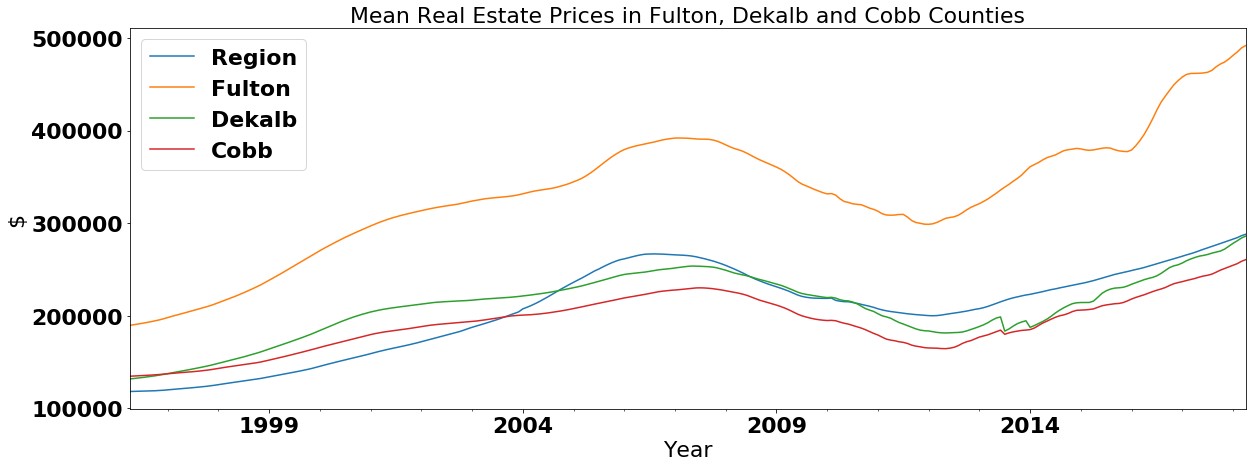

In [32]:
summary_df.plot(figsize=(20,7),legend=True)
plt.title("Mean Real Estate Prices in Fulton, Dekalb and Cobb Counties",{'size':22});
plt.xlabel("Year",{'size':22})
plt.ylabel("$",{'size':22})

# 3) Finding Georgia's "Best ZIP Codes"

#### Filter zip codes by best zip code criteria and company preferences.
#### The real estate investment firm wants to know the top 5 zipcodes to invest in.



## 

## "Best ZIP Code" Criteria:

### 1) Urbanization - Zip Code must be in top 50% according to sizerank variable.
    ** Traffic makes Commuting from the Greater Atlanta area into the city brutal ... So living within a 45min driving distance to work is essential.
    ** I hypothesize that the best investment opportunities will be found just outside the perimeter in growing suburbs.

### 2) Median House price
    ** House price should be close to the Median house price for that zipcode, preferably lower.
    ** Range - 1.5 decile below and 1 decile above.

### 3) ROI (Return on investment)
    ** Investment Company wants to know which zipcodes will have the greatest 10 year ROI.

### 4) Risk
    ** Risk averse investment company. Zip codes to be selected according to a coefficient of variation below 70th percentile.

In [33]:
print(df_GA_2.SizeRank.describe(),'\n')

count       59.000000
mean      2861.525424
std       2731.942421
min        214.000000
25%       1058.000000
50%       1927.000000
75%       3606.000000
max      11325.000000
Name: SizeRank, dtype: float64 



#### 1) Urbanization - Zip Code must be in top 50% according to sizerank variable.

In [34]:
GA_sr_50 = df_GA_2.SizeRank.quantile(q=0.50)
print(f'GA Size Rank 50% cutoff value: {GA_sr_50}')

GA Size Rank 50% cutoff value: 1927.0


In [35]:
GA_zc_t50 = df_GA_2[df_GA_2['SizeRank']<GA_sr_50].drop(['RegionID','City','State','Metro','CountyName','SizeRank'],axis=1)
print(f'# of zipcodes: {len(GA_zc_t50)}')

# of zipcodes: 29


#### 2) Average House price

In [36]:
GA_zc_t50['yr_avg']=GA_zc_t50.iloc[:,-12:].mean(skipna=True, axis=1)

In [37]:
print(GA_zc_t50['yr_avg'].describe(),'\n')

count        29.000000
mean     333658.045977
std      195860.519484
min      116466.666667
25%      188908.333333
50%      277141.666667
75%      412816.666667
max      874691.666667
Name: yr_avg, dtype: float64 



In [38]:
q_60 = GA_zc_t50['yr_avg'].quantile(q=0.60)
print(f'Avg 60% Cutoff Value: {round(q_60,2)}')

Avg 60% Cutoff Value: 337753.33


In [39]:
q_35 = GA_zc_t50['yr_avg'].quantile(q=0.35)
print(f'Avg 35% Cutoff Value: {round(q_35,2)}')

Avg 35% Cutoff Value: 219516.67


In [40]:
# Get data frame with filtered zip codes

zc_filtered = GA_zc_t50[(GA_zc_t50['yr_avg']<q_60) & (GA_zc_t50['yr_avg']>q_35)]
print(f'Number of Zipcodes: {len(zc_filtered)}')

Number of Zipcodes: 7


#### 3) (ROI) Return on Investment

In [41]:
zc_filtered['ROI'] = (zc_filtered['2018-04']/zc_filtered['1996-04'])-1

In [42]:
zc_filtered['std'] = zc_filtered.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)

In [43]:
zc_filtered['mean'] = zc_filtered.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)

#### 4) Risk - Coefficient of Variation below 70th percentile.

In [44]:
zc_filtered['CV'] = zc_filtered['std']/zc_filtered['mean']

In [45]:
zc_filtered[['RegionName','std','mean','ROI','CV']].head()

,RegionName,std,mean,ROI,CV
213,30080,39919.584647,213763.396226,1.338346,0.186747
221,30062,42293.095620,226361.509434,1.191333,0.186839
440,30066,28359.729404,176089.811321,1.028869,0.161053
495,30101,22891.755053,172782.264151,0.704562,0.132489
1017,30064,32823.525473,207401.132075,0.949728,0.158261


In [46]:
print(zc_filtered.CV.describe())
cv_upper = zc_filtered.CV.quantile(.7)
print(f'\nCV Upper Limit: {cv_upper}')

count    7.000000
mean     0.186609
std      0.069124
min      0.132489
25%      0.151275
50%      0.161053
75%      0.186793
max      0.336582
Name: CV, dtype: float64

CV Upper Limit: 0.18676501434287818


In [47]:
zc_best = zc_filtered[zc_filtered['CV']<cv_upper].sort_values('ROI', axis=0,ascending=False)[:5]
zc_best.head()

,RegionName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-12,2018-01,2018-02,2018-03,2018-04,yr_avg,ROI,std,mean,CV
213,30080,133000.0,133100.0,133100.0,133200.0,133200.0,133300.0,133500.0,133800.0,134300.0,...,297100,299400,302400,307100,311000,292850.000000,1.338346,39919.584647,213763.396226,0.186747
440,30066,124700.0,124900.0,125100.0,125400.0,125700.0,126000.0,126400.0,126800.0,127300.0,...,245400,247300,249100,251300,253000,242458.333333,1.028869,28359.729404,176089.811321,0.161053
1017,30064,147200.0,147600.0,147900.0,148300.0,148700.0,149100.0,149500.0,149900.0,150400.0,...,279500,281600,283600,285800,287000,277141.666667,0.949728,32823.525473,207401.132075,0.158261
1797,30152,150800.0,151100.0,151500.0,151900.0,152400.0,152900.0,153400.0,153900.0,154500.0,...,268700,270300,271700,273200,274200,264991.666667,0.818302,29736.581038,206089.811321,0.144289
495,30101,133700.0,133700.0,133700.0,133700.0,133700.0,133700.0,133800.0,133800.0,133900.0,...,221500,222700,224300,226400,227900,220041.666667,0.704562,22891.755053,172782.264151,0.132489


In [48]:
print('\n Top 5 Zipcodes to Invest in')
zc_best[['RegionName','ROI','CV']]


 Top 5 Zipcodes to Invest in


,RegionName,ROI,CV
213,30080,1.338346,0.186747
440,30066,1.028869,0.161053
1017,30064,0.949728,0.158261
1797,30152,0.818302,0.144289
495,30101,0.704562,0.132489


## Top 5 Zipcodes

#### Zipcode 30080 - Smyrna, GA
#### Zipcode 30066 - Marietta, GA
#### Zipcode 30064 - Marietta, GA
#### Zipcode 30152 - Kennesaw, GA 
#### Zipcode 30101 - Acworth, GA

# 

# 4) Time Series Analysis
    a) Reshaped data from wide to long format by melting
    b) Set 'time' column as index

In [49]:
ts_t5 = zc_best.drop(['yr_avg','std','mean','ROI','CV'],axis=1)
ts_t5 = melt_data(ts_t5).set_index('time')
print('Time series data - Top 5 zipcodes:\n',ts_t5.head())

ts = []
for zc in ts_t5.RegionName.unique():
    df_ts = ts_t5[ts_t5['RegionName']==zc].asfreq('MS')
    ts.append(df_ts)

print('\nZipcode 30080 time series:')
ts[0].head()

Time series data - Top 5 zipcodes:
             RegionName     value
time                            
1996-04-01       30080  133000.0
1996-04-01       30066  124700.0
1996-04-01       30064  147200.0
1996-04-01       30152  150800.0
1996-04-01       30101  133700.0

Zipcode 30080 time series:


,RegionName,value
time,,
1996-04-01,30080,133000.0
1996-05-01,30080,133100.0
1996-06-01,30080,133100.0
1996-07-01,30080,133200.0
1996-08-01,30080,133200.0


    c) Look at descriptive stats and plot time series to visually look for seasonality and other trends

In [50]:
for i in range(len(ts)):
    print(f'Descriptive statistics for zipcode {ts[i].RegionName[0]}:')
    print(f'{ts[i].value.describe()}\n')

Descriptive statistics for zipcode 30080:
count       265.000000
mean     213763.396226
std       39919.584647
min      133000.000000
25%      187800.000000
50%      217700.000000
75%      241700.000000
max      311000.000000
Name: value, dtype: float64

Descriptive statistics for zipcode 30066:
count       265.000000
mean     176089.811321
std       28359.729404
min      124700.000000
25%      156200.000000
50%      176100.000000
75%      194600.000000
max      253000.000000
Name: value, dtype: float64

Descriptive statistics for zipcode 30064:
count       265.000000
mean     207401.132075
std       32823.525473
min      147200.000000
25%      184800.000000
50%      207100.000000
75%      231600.000000
max      287000.000000
Name: value, dtype: float64

Descriptive statistics for zipcode 30152:
count       265.000000
mean     206089.811321
std       29736.581038
min      150800.000000
25%      184600.000000
50%      207600.000000
75%      229200.000000
max      274200.000000
Name: val

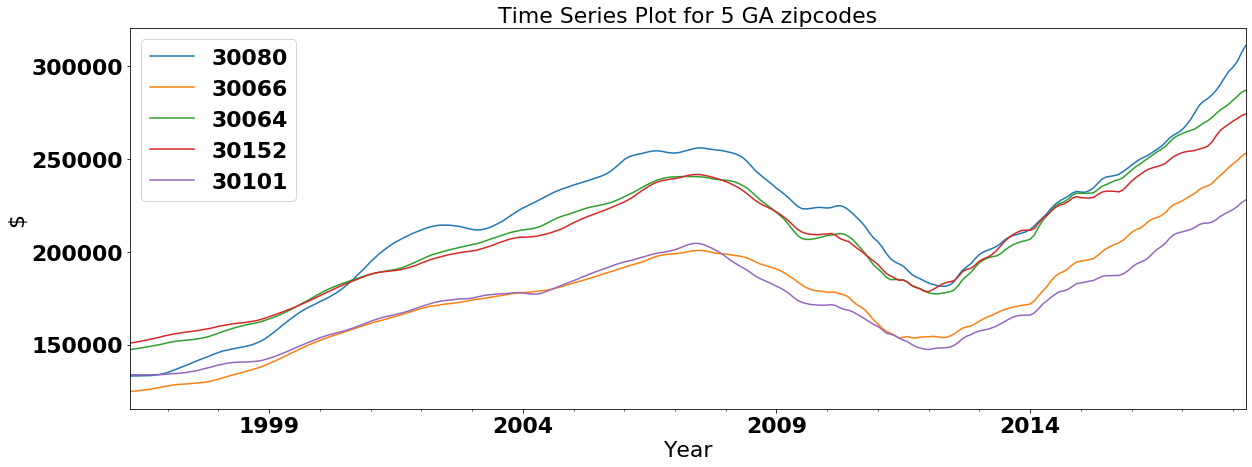

In [51]:
for i in range(5):
    ts[i].value.plot(label=ts[i].RegionName[0],figsize=(20,7),legend=True)
    plt.legend
    plt.title("Time Series Plot for 5 GA zipcodes",{'size':22});
    plt.xlabel("Year",{'size':22})
    plt.ylabel("$",{'size':22})

### Observation:
    ** I can see an overall positive trend year to year, but I want to dig a little deeper and look month to month.
    ** Let's compare the top5 Zip Codes by monthly returns ("mr").

In [52]:
for z in range(len(ts)):
    ts[z]['mr']=np.nan*len(ts[z])
    for i in range(len(ts[z])-1):
        ts[z]['mr'][i+1] = (ts[z].value.iloc[i+1] / ts[z].value.iloc[i]) -1

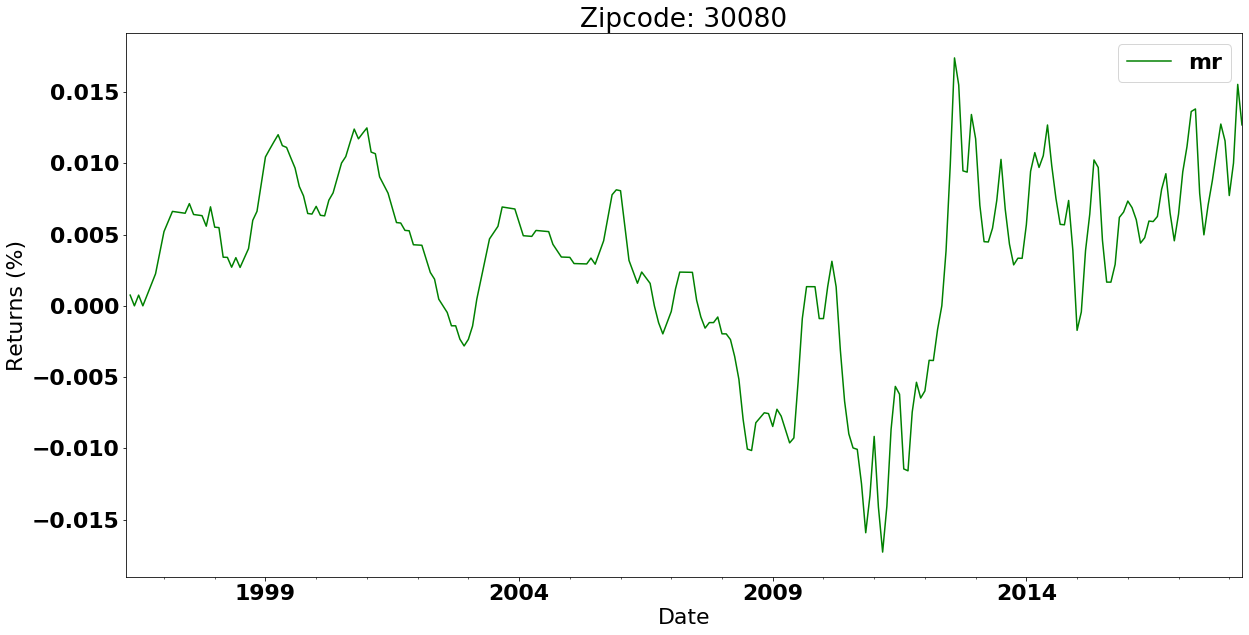

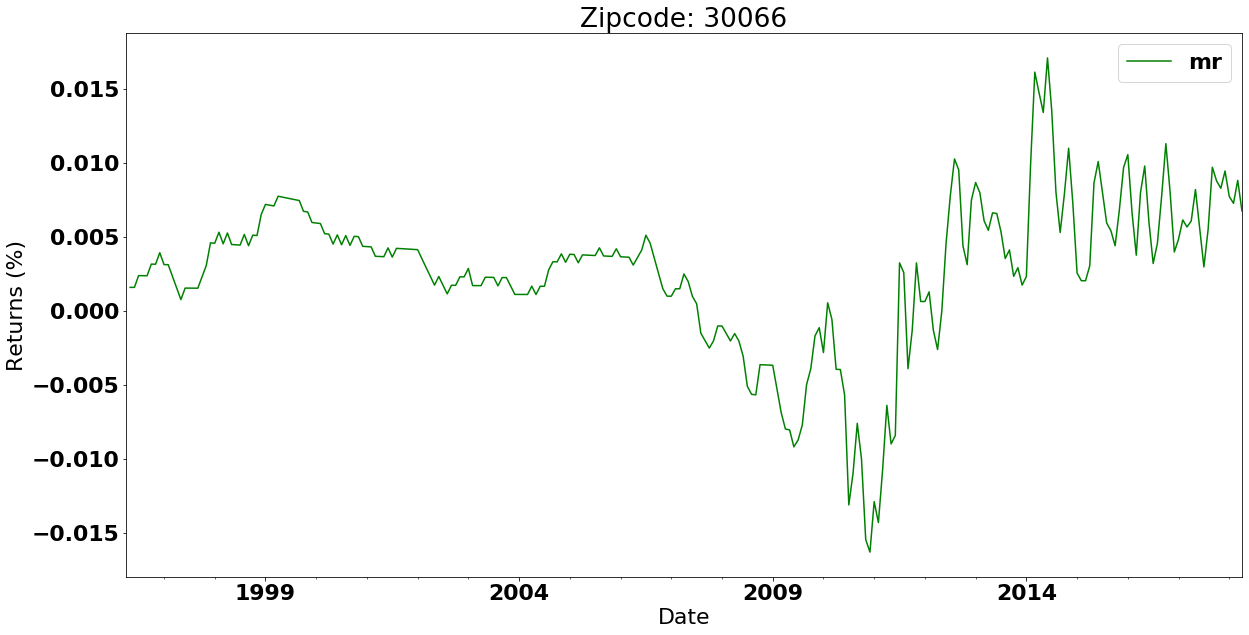

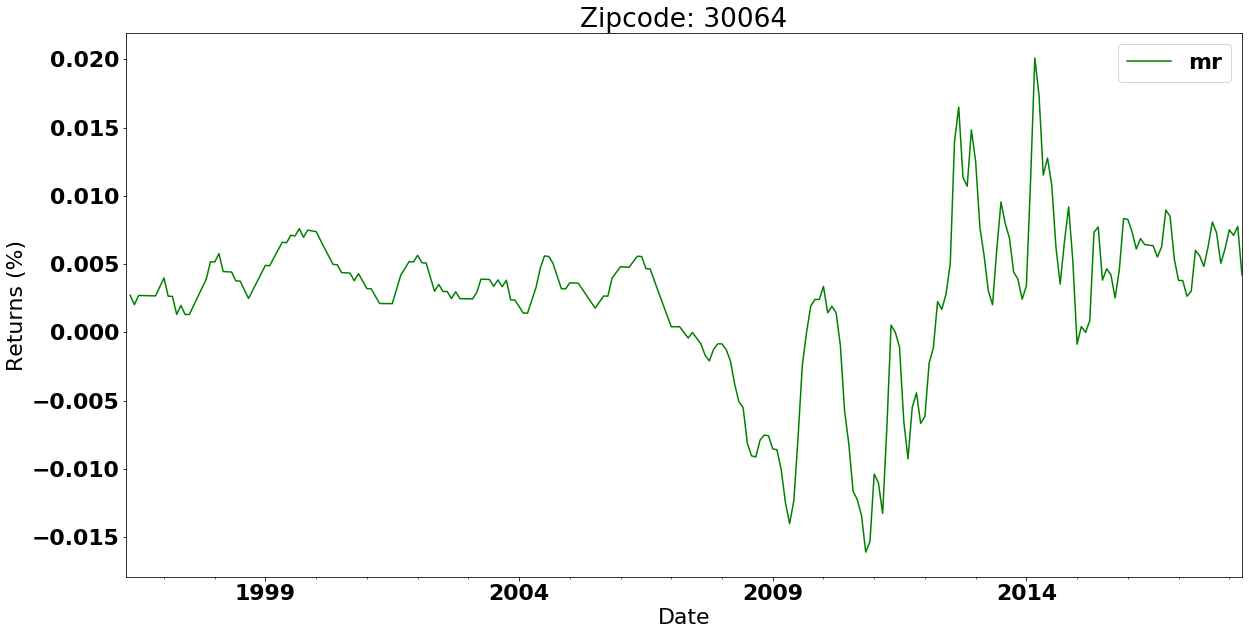

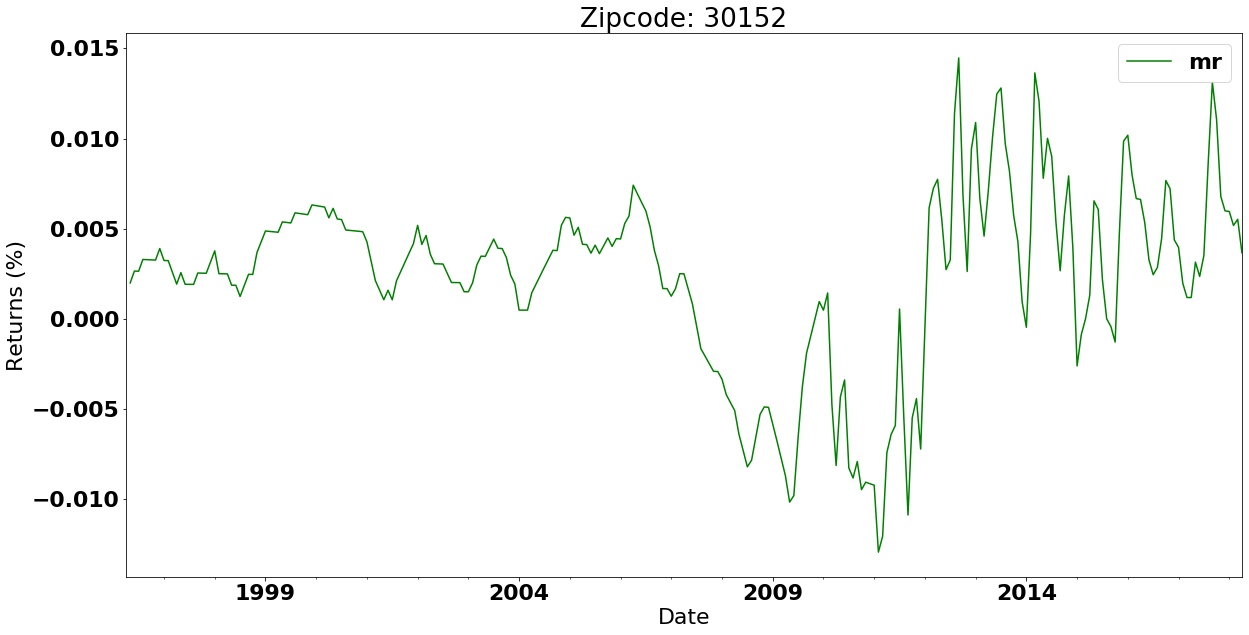

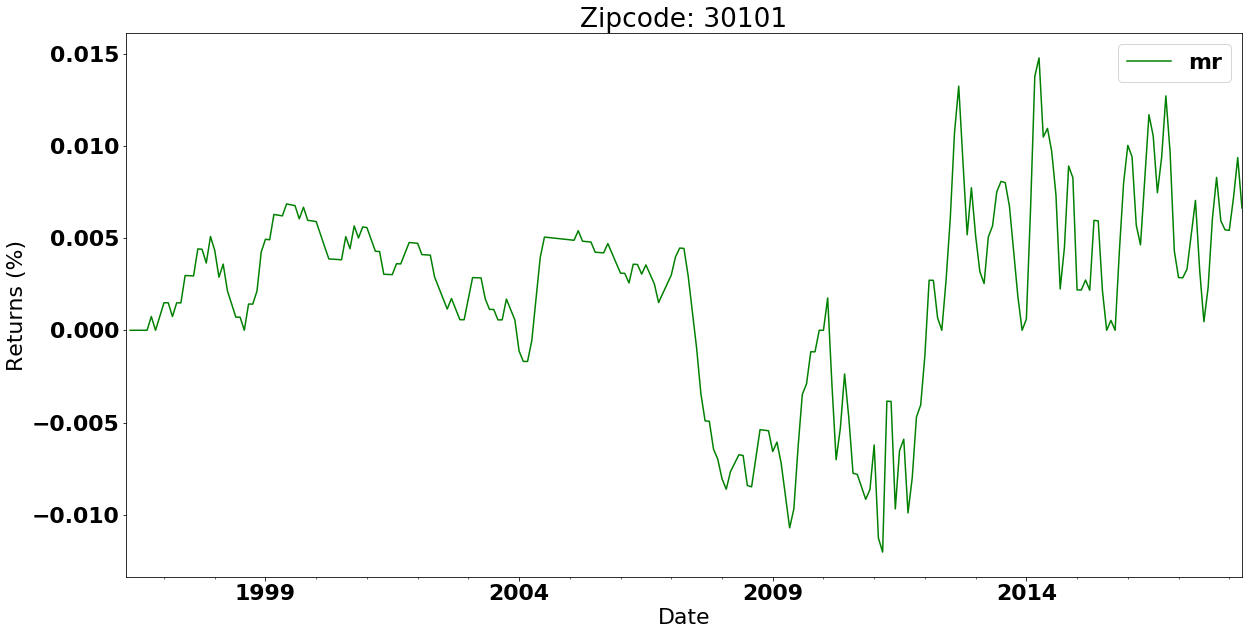

In [53]:
for i in range(len(ts)):
    ts[i].mr.plot(figsize=(20,10), color = 'g')
    plt.title(f'Zipcode: {ts[i].RegionName[0]}')
    plt.xlabel('Date')
    plt.ylabel('Returns (%)')
    plt.legend(loc='best')
    plt.show()

### Calculate rolling mean & Standard Deviation

    ** Visualize to look for trends and to see if the data is stationary.

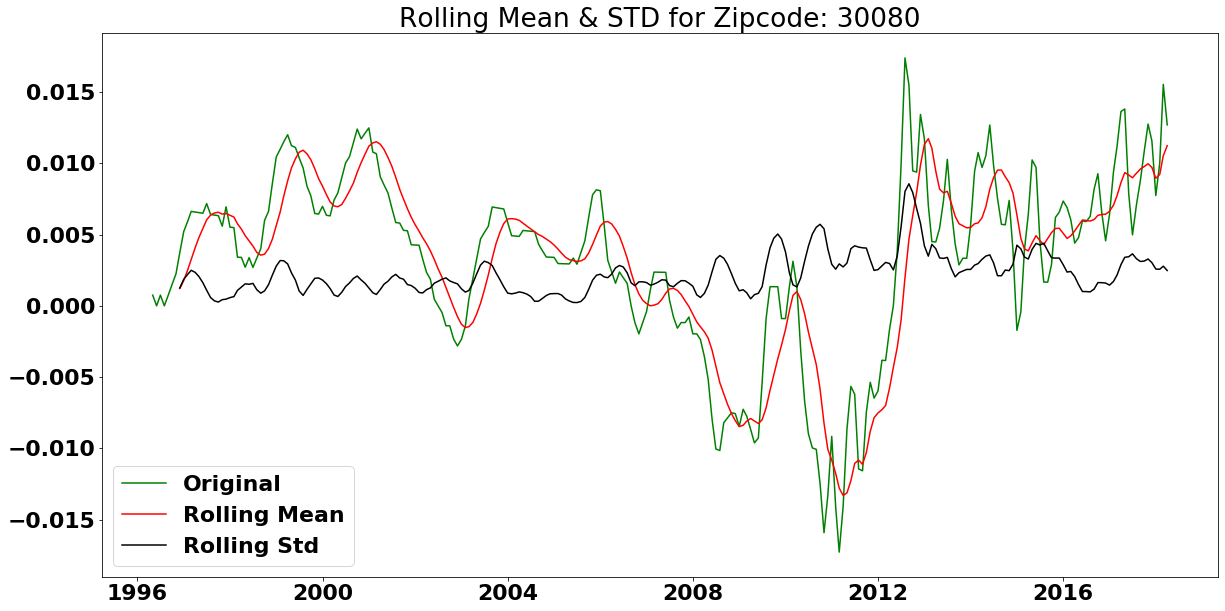

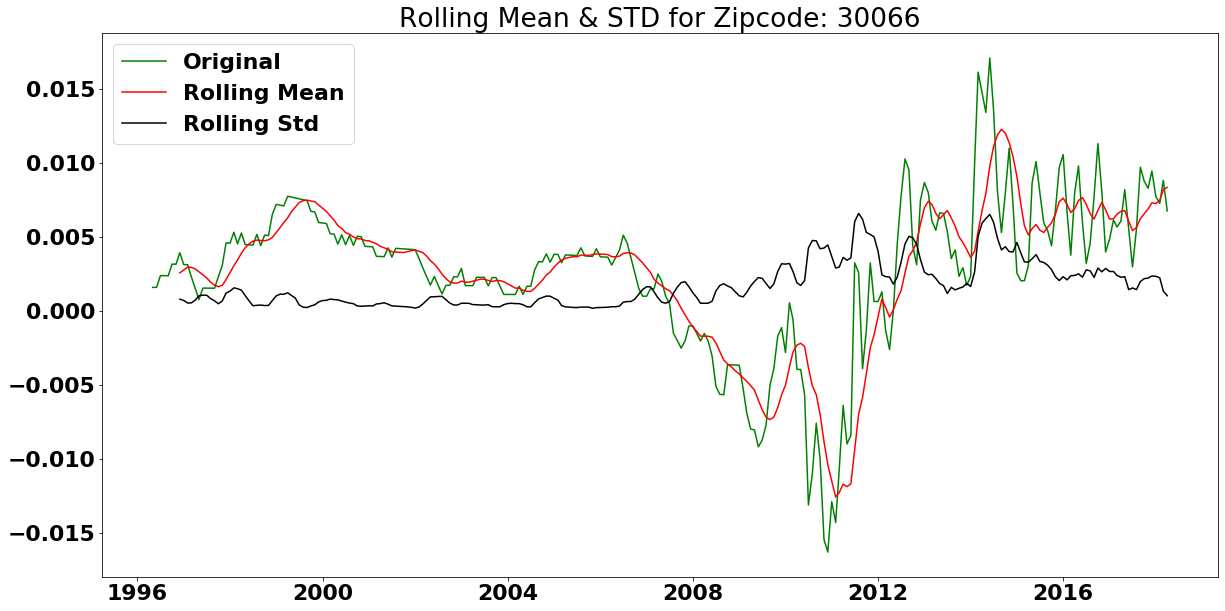

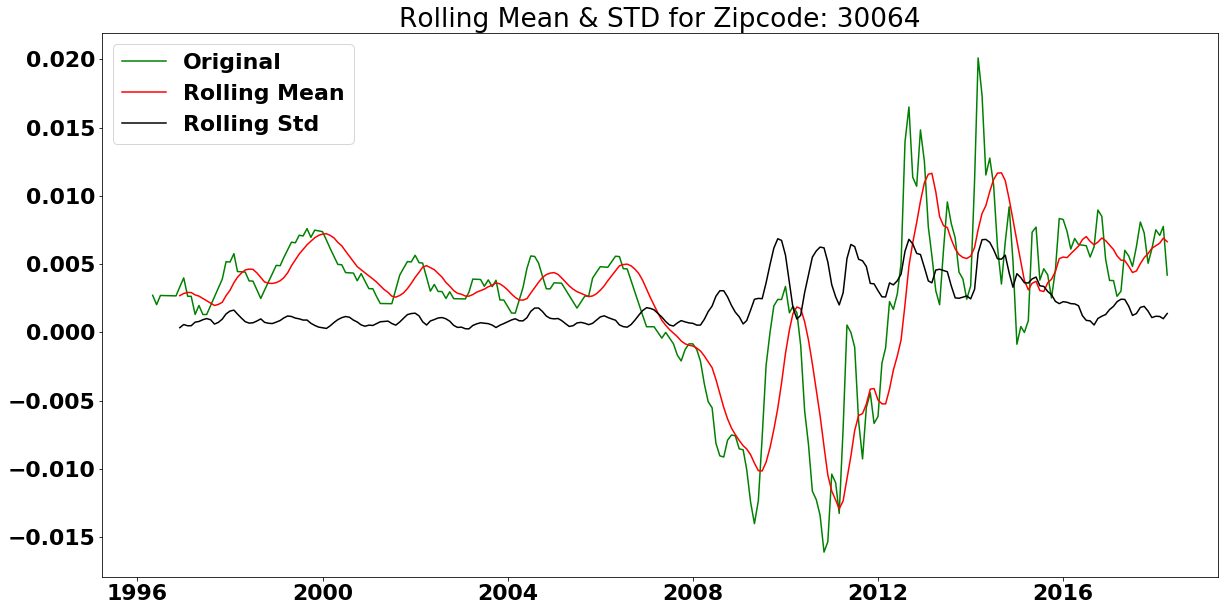

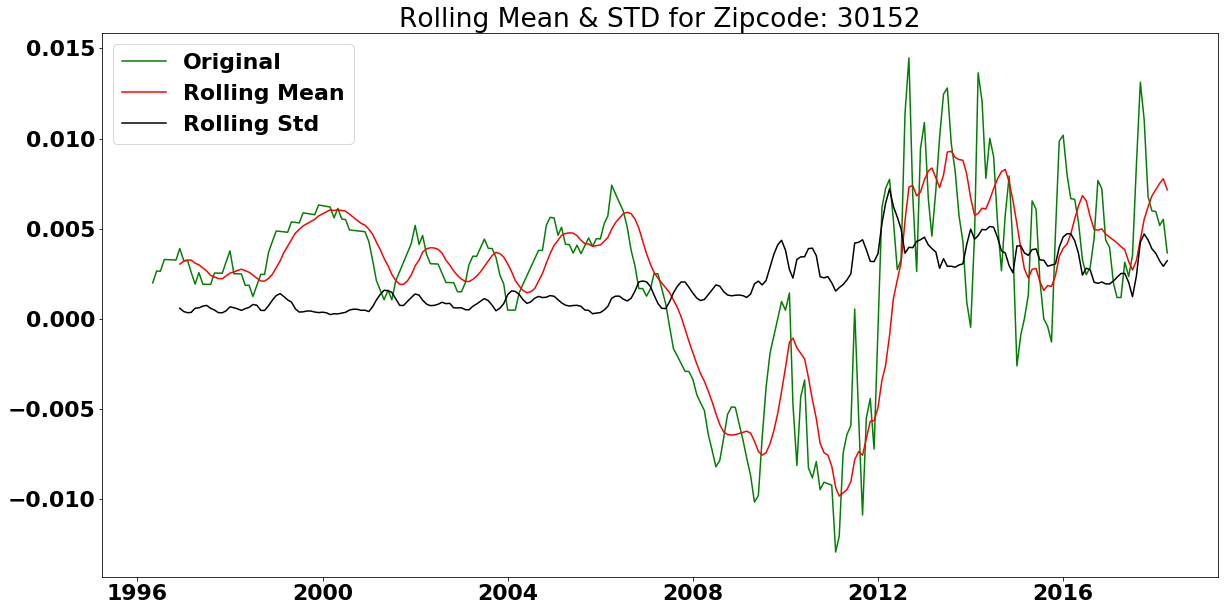

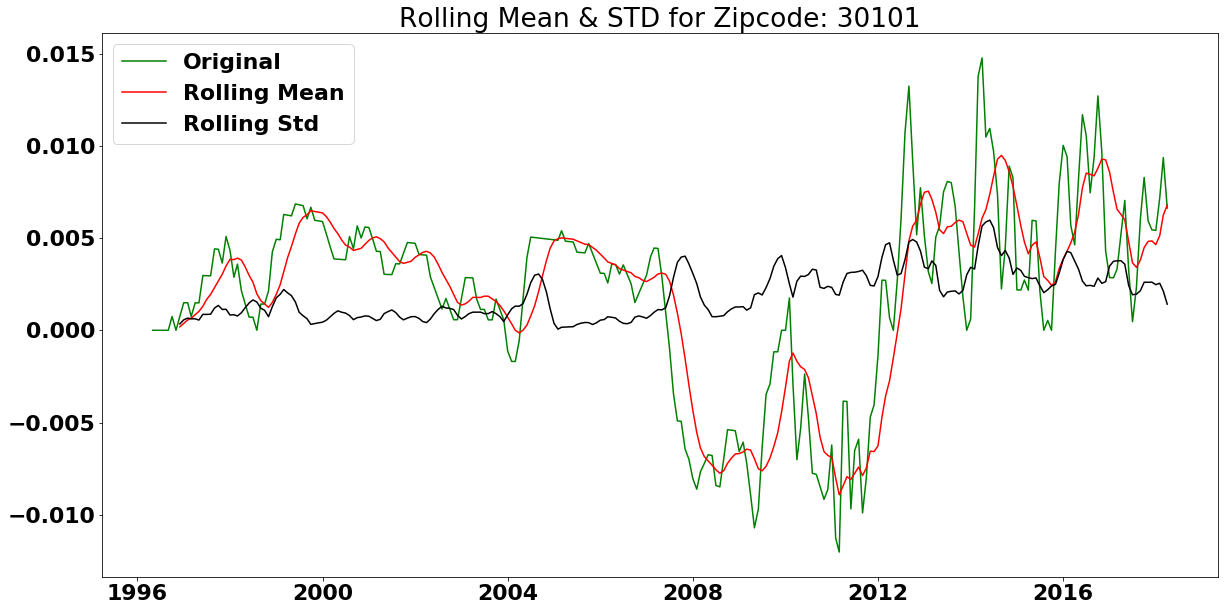

In [54]:
for i in range(len(ts)):
    roll_mean = ts[i].mr.rolling(window=8, center=False).mean()
    roll_std = ts[i].mr.rolling(window=8, center=False).std()
    
    fig = plt.figure(figsize=(20,10))
    orig = plt.plot(ts[i].mr, color='green',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & STD for Zipcode: {ts[i].RegionName[0]}')
    plt.show()

    ** No clear trends. Data looks stationary.

### Dickey-Fuller Test - Test stationarity
    h0 = time series is NOT stationary
    *** if p-value <0.05, we reject the null-hypothesis
https://machinelearningmastery.com/time-series-data-stationary-python/

In [55]:
for i in range(5):
    dftest = adfuller(ts[i].mr.dropna())
    print(f'ADFuller test p-value for zip code: {ts[i].RegionName[0]}')
    print('p-value:',dftest[1])
    if dftest[1]>0.05:
        print('We fail to reject the null hypothesis H0. The data is NOT stationary.\n')
    else:
        print('We reject the null hypothesis H0. The data is stationary.\n')

ADFuller test p-value for zip code: 30080
p-value: 0.10582668020507491
We fail to reject the null hypothesis H0. The data is NOT stationary.

ADFuller test p-value for zip code: 30066
p-value: 0.40135495914414054
We fail to reject the null hypothesis H0. The data is NOT stationary.

ADFuller test p-value for zip code: 30064
p-value: 0.43644912328630764
We fail to reject the null hypothesis H0. The data is NOT stationary.

ADFuller test p-value for zip code: 30152
p-value: 0.08962915917599712
We fail to reject the null hypothesis H0. The data is NOT stationary.

ADFuller test p-value for zip code: 30101
p-value: 0.1848218706788976
We fail to reject the null hypothesis H0. The data is NOT stationary.



#### Differencing to make data stationary by removing trends and seasonality.

In [56]:
for i in [0,1,2,3,4]:
    dftest = adfuller(ts[i].mr.diff().dropna())
    print(f'ADFuller test p-value for zip code: {ts[i].RegionName[0]}')
    print('p-value:',dftest[1])
    if dftest[1]>0.05:
        print('We fail to reject the null hypothesis H0. Data is Non-stationary.\n')
    else:
        print('We reject the null hypothesis H0. Data is stationary.\n')

ADFuller test p-value for zip code: 30080
p-value: 7.5012888900277046e-06
We reject the null hypothesis H0. Data is stationary.

ADFuller test p-value for zip code: 30066
p-value: 1.6411543749960408e-06
We reject the null hypothesis H0. Data is stationary.

ADFuller test p-value for zip code: 30064
p-value: 7.68917318547343e-13
We reject the null hypothesis H0. Data is stationary.

ADFuller test p-value for zip code: 30152
p-value: 0.00016896829541302393
We reject the null hypothesis H0. Data is stationary.

ADFuller test p-value for zip code: 30101
p-value: 9.757571224626924e-11
We reject the null hypothesis H0. Data is stationary.



### Insight:

#### a) Naked eye test tells us that the data looks stationary, but the Dickey-Fuller Test says the data is not stationary.
#### b) "i" is most likely 1 since all 5 zipcodes were not stationary
#### c) If the data was stationary, "i" would have been 0

In [57]:
ts_30080 = ts[0].mr.dropna() #Zip code 30080 monthly returns time series
ts_30080_diff = ts[0].mr.diff().dropna() #Zip code 30080 monthly returns differenced time series

ts_30066 = ts[1].mr.dropna() #Zip code 30066 monthly returns time series
ts_30066_diff = ts[1].mr.diff().dropna() #Zip code 30066 monthly returns differenced time series

ts_30064 = ts[2].mr.dropna() #Zip code 30064 monthly returns time series
ts_30064_diff = ts[2].mr.diff().dropna() #Zip code 30064 monthly returns differenced time series

ts_30152 = ts[3].mr.dropna() #Zip code 30152 monthly returns time series
ts_30152_diff = ts[3].mr.diff().dropna() #Zip code 30152 monthly returns differenced time series

ts_30101 = ts[4].mr.dropna() #Zip code 30101 monthly returns time series
ts_30101_diff = ts[4].mr.diff().dropna() #Zip code 30101 monthly returns differenced time series


# 5) SARIMA Modeling

### 5a) Zip code #1 : 30080 (Smyrna, GA)

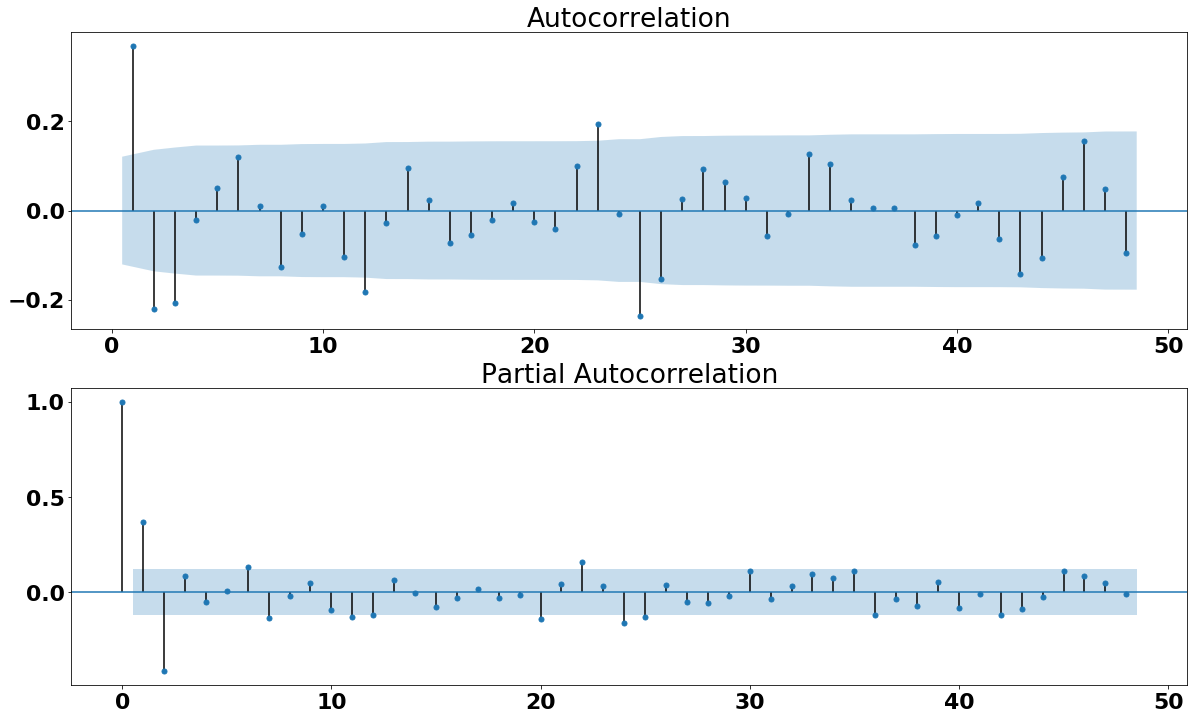

In [58]:
acf_pacf(ts_30080_diff)

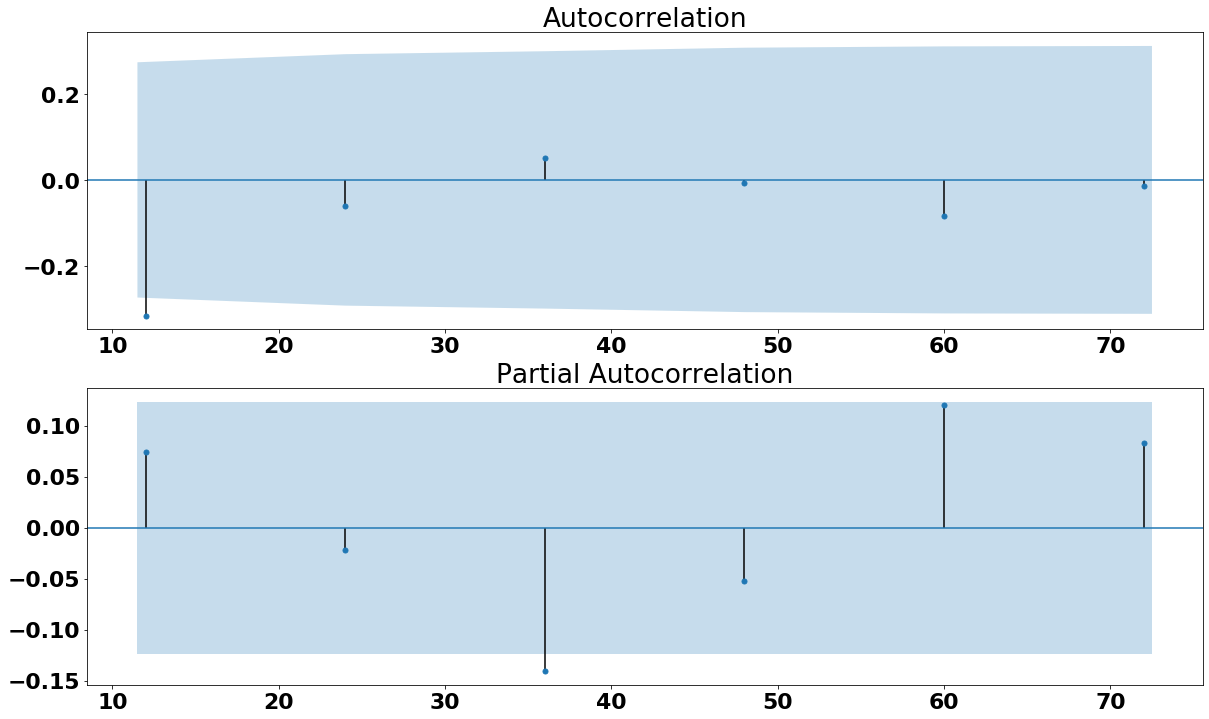

In [59]:
seasonal_plots(ts_30080_diff, N=13)

In [60]:
dftest = pm.auto_arima(ts_30080_diff,information_criterion='aic',m=12,d=1,stepwise=True,trace=True,
                        error_action='ignore',suppress_warnings=True)
dftest

#d=0 if data was originally non-stationary
#d=1 if data was stationary after we took difference

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-2596.038, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-2463.633, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-2469.617, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-2471.004, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-2465.628, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-2599.114, Time=0.68 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-2592.354, Time=0.36 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-2596.877, Time=1.11 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-2598.359, Time=0.42 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-2593.711, Time=1.92 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=-2558.321, Time=0.62 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=-2564.060, Time=0.35 sec
 ARIMA(3,1,2)(0,0,1)[12] intercept   : AIC=-2461.897, Time=0.24 sec
 ARIMA(2,1,3)(0,0,1)[12] intercept   : AIC=-2600.408, Time=0.63 sec
 ARIM

ARIMA(order=(0, 1, 4), scoring_args={}, seasonal_order=(0, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

                                      SARIMAX Results                                       
Dep. Variable:                                   mr   No. Observations:                  228
Model:             SARIMAX(0, 1, 4)x(0, 0, [1], 12)   Log Likelihood                1157.158
Date:                              Wed, 16 Sep 2020   AIC                          -2302.317
Time:                                      09:59:31   BIC                          -2281.767
Sample:                                  05-01-1996   HQIC                         -2294.025
                                       - 04-01-2015                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6248      0.050     12.374      0.000       0.526       0.724
ma.L2         -0.07

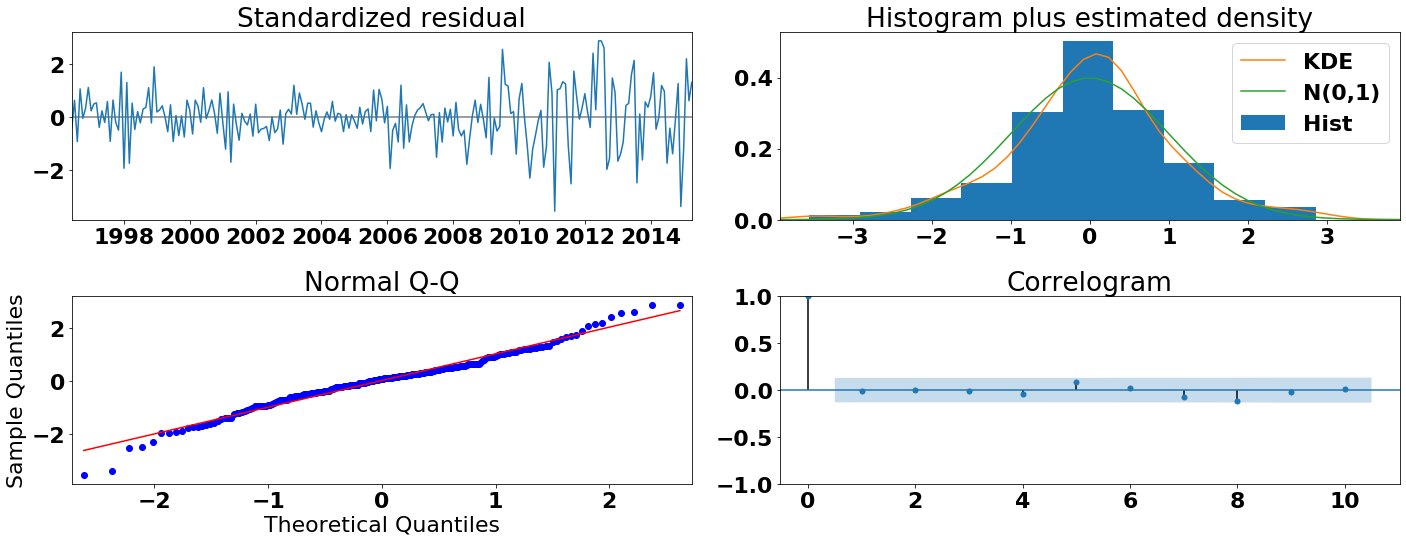

In [61]:
# SARIMA model parameters
# p = 0 d = 1 q = 4
# P = 0 D = 0 Q = 1 S = 12

# Fit SARIMA model
pdq = (0,1,4)
pdqs = (0,0,1,12)
train, test, results = model_fit(ts_30080,pdq=pdq,pdqs=pdqs)

SARIMA model RMSE on train data: 0.00228


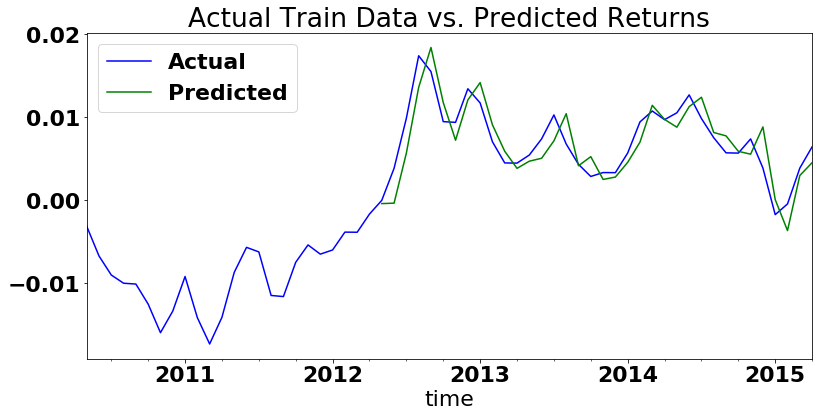

In [62]:
train_RMSE(train, results)

SARIMA model RMSE on test data: 0.00207


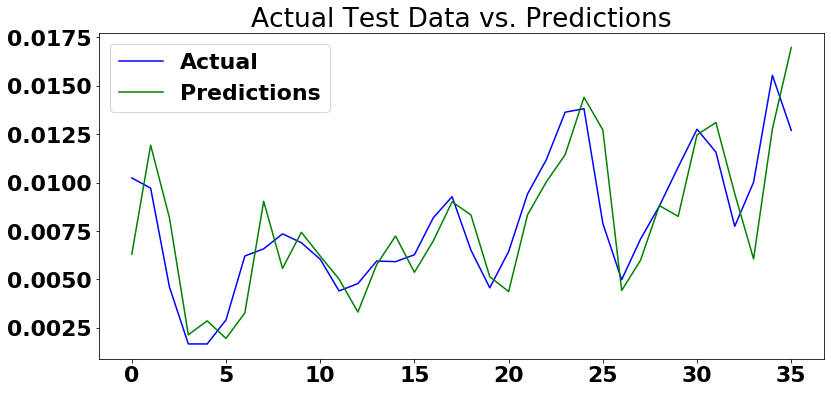

In [63]:
test_RMSE(ts_30080,pdq=pdq,pdqs=pdqs, display=True)

    ** Both predictions are very close to the actual data. RMSE are very close to each other.

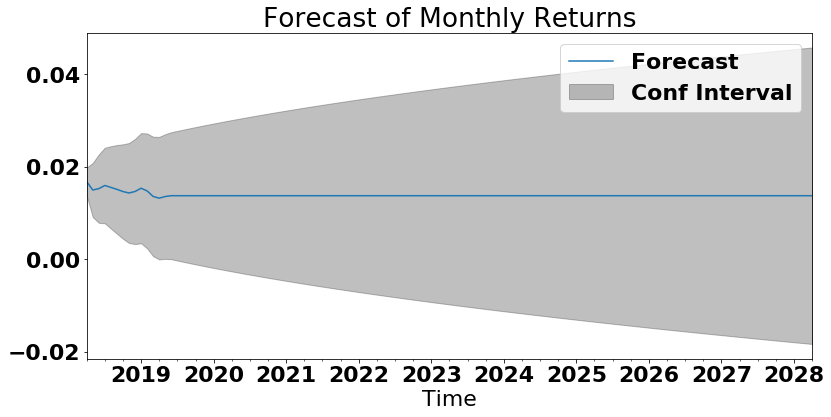

Expected 1yr return: 19.71%
Expected 3yr return: 66.07%
Expected 5yr return: 130.53%
Expected 10yr return: 430.63%


In [64]:
mr_30080=forecast_model(ts_30080,pdq=pdq,pdqs=pdqs, z=30080)

### 5b) Zip code #2 : 30066 (Marietta, GA)

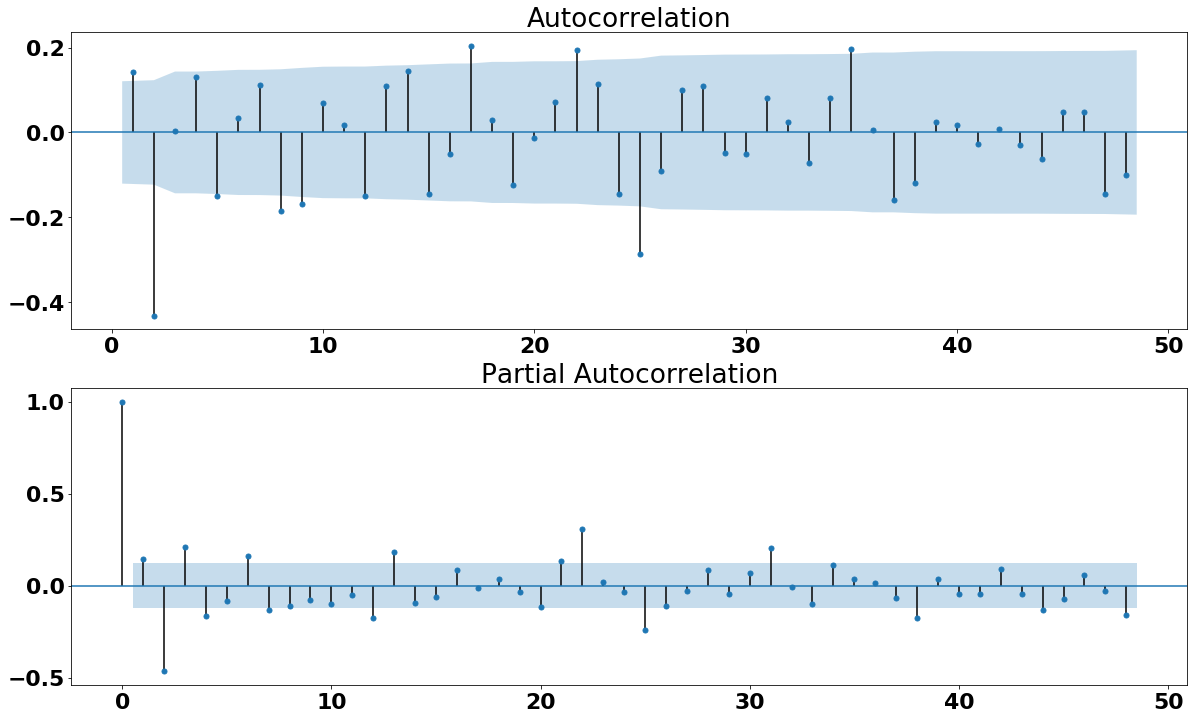

In [65]:
acf_pacf(ts_30066_diff)

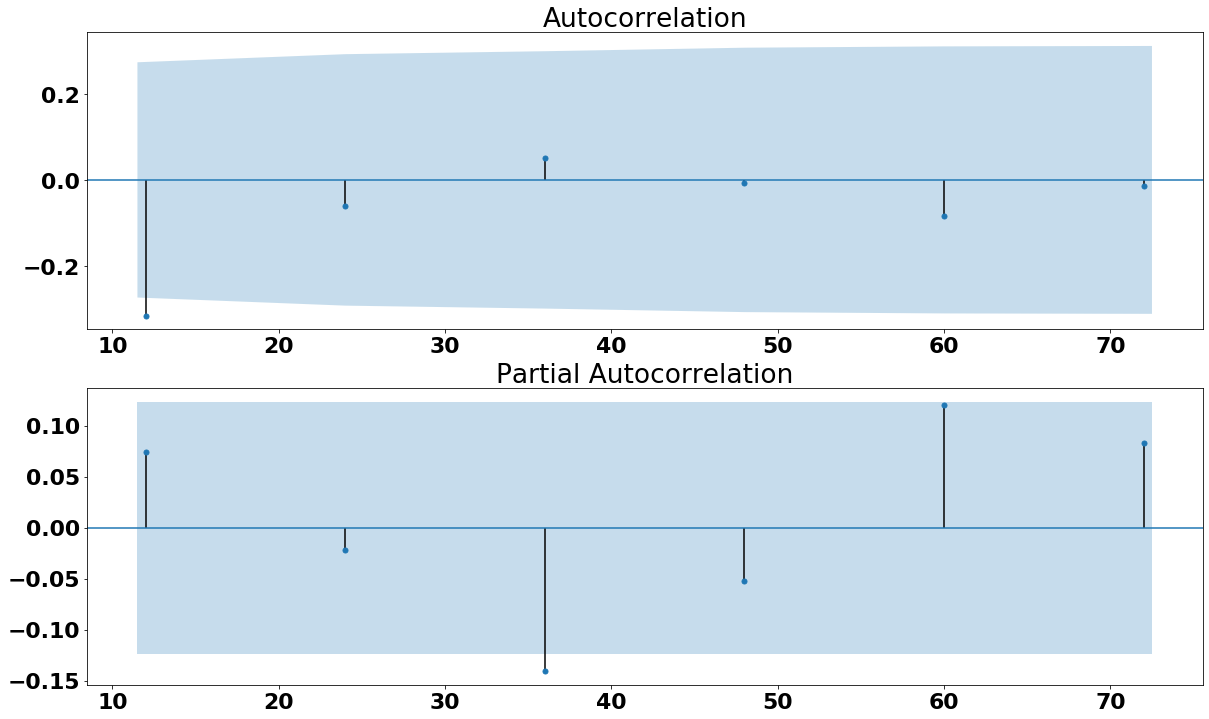

In [66]:
seasonal_plots(ts_30066_diff, N=13)

In [67]:
dftest = pm.auto_arima(ts_30066_diff,information_criterion='aic',m=12,d=1,stepwise=True,trace=True,
                        error_action='ignore',suppress_warnings=True)
dftest

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-2541.858, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-2367.507, Time=0.13 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-2384.674, Time=0.25 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-2417.312, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-2369.503, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-2549.442, Time=0.32 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-2547.015, Time=0.27 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-2542.836, Time=1.74 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-2547.948, Time=0.33 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-2538.396, Time=1.58 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=-2387.882, Time=0.57 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=-2508.219, Time=0.24 sec
 ARIMA(3,1,2)(0,0,1)[12] intercept   : AIC=-2380.356, Time=0.29 sec
 ARIMA(2,1,3)(0,0,1)[12] intercept   : AIC=-2567.460, Time=0.80 sec
 ARIM

ARIMA(order=(1, 1, 5), scoring_args={}, seasonal_order=(0, 0, 2, 12),
      suppress_warnings=True, with_intercept=False)

                                        SARIMAX Results                                        
Dep. Variable:                                      mr   No. Observations:                  228
Model:             SARIMAX(1, 1, 5)x(0, 0, [1, 2], 12)   Log Likelihood                1136.159
Date:                                 Wed, 16 Sep 2020   AIC                          -2254.317
Time:                                         10:00:20   BIC                          -2223.492
Sample:                                     05-01-1996   HQIC                         -2241.879
                                          - 04-01-2015                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0631      0.464      0.136      0.892      -0.846       0

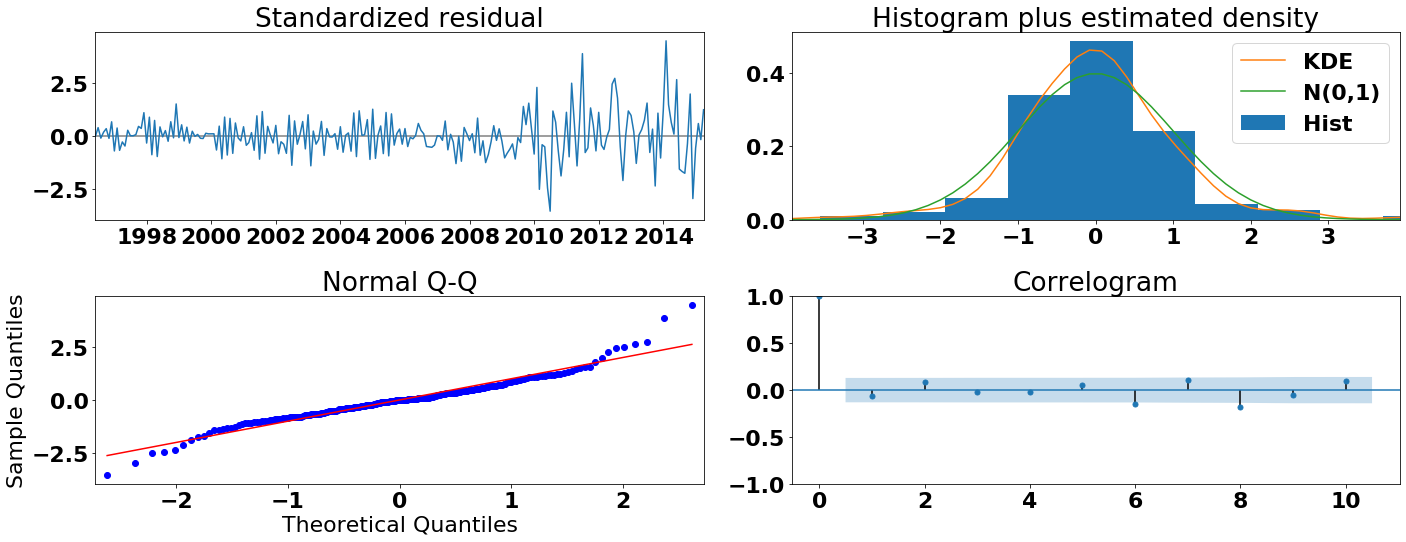

In [68]:
# SARIMA model parameters
# p = 1 d = 1 q = 5
# P = 0 D = 0 Q = 2 S = 12

# Fit SARIMA model
pdq = (1,1,5)
pdqs = (0,0,2,12)
train, test, results = model_fit(ts_30066,pdq=pdq,pdqs=pdqs)

SARIMA model RMSE on train data: 0.00256


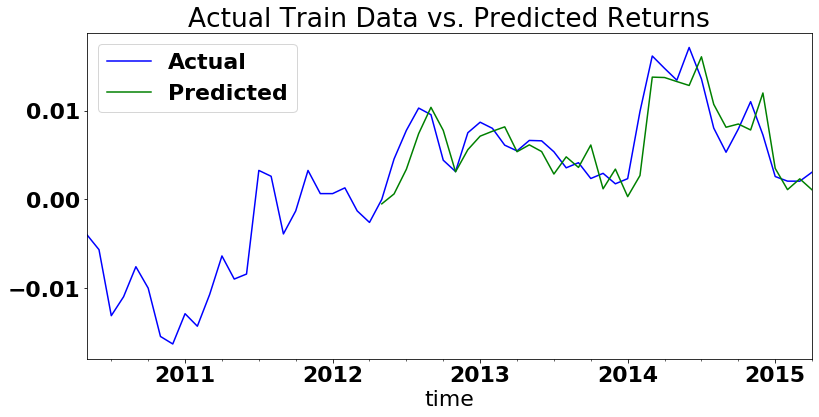

In [69]:
train_RMSE(train, results)

SARIMA model RMSE on test data: 0.00201


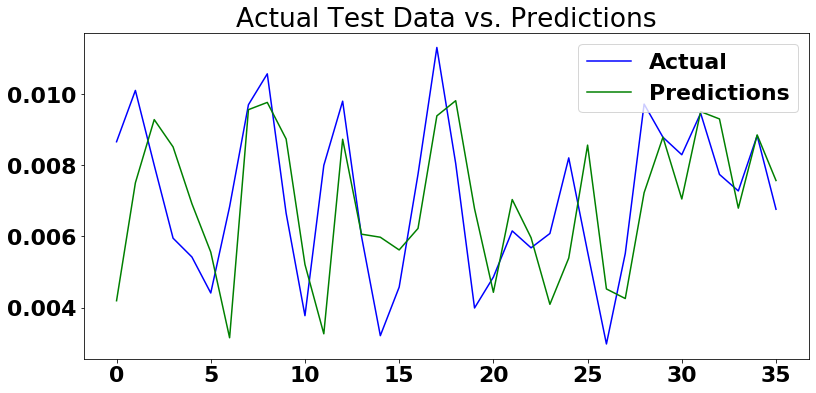

In [70]:
test_RMSE(ts_30066,pdq=pdq,pdqs=pdqs, display=True)

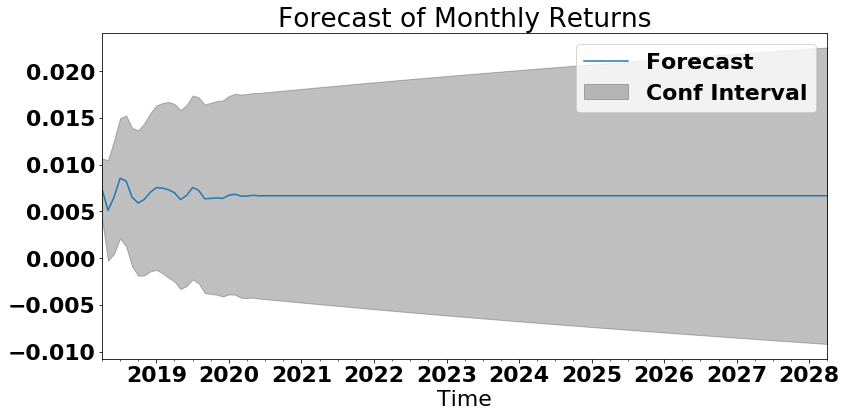

Expected 1yr return: 8.71%
Expected 3yr return: 27.57%
Expected 5yr return: 49.64%
Expected 10yr return: 124.47%


In [71]:
mr_30066=forecast_model(ts_30066,pdq=pdq,pdqs=pdqs, z=30066)

### 5c) Zip code #3 : 30064 (Marietta, GA)

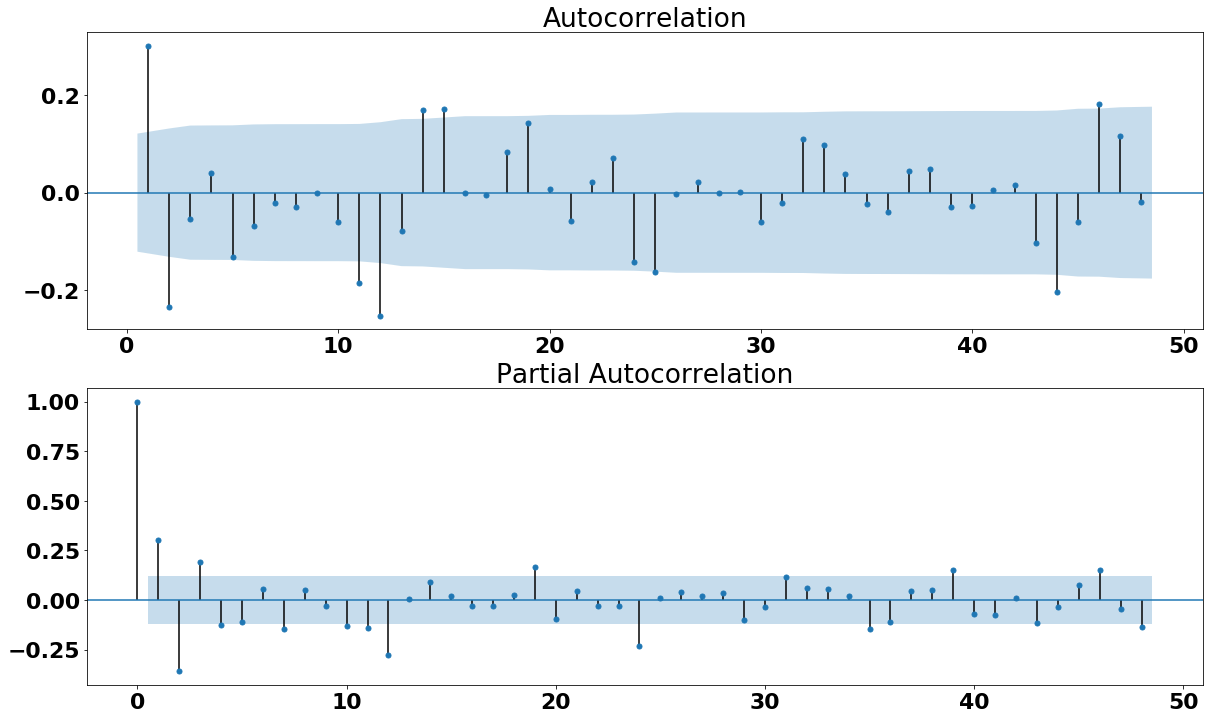

In [72]:
acf_pacf(ts_30064_diff)

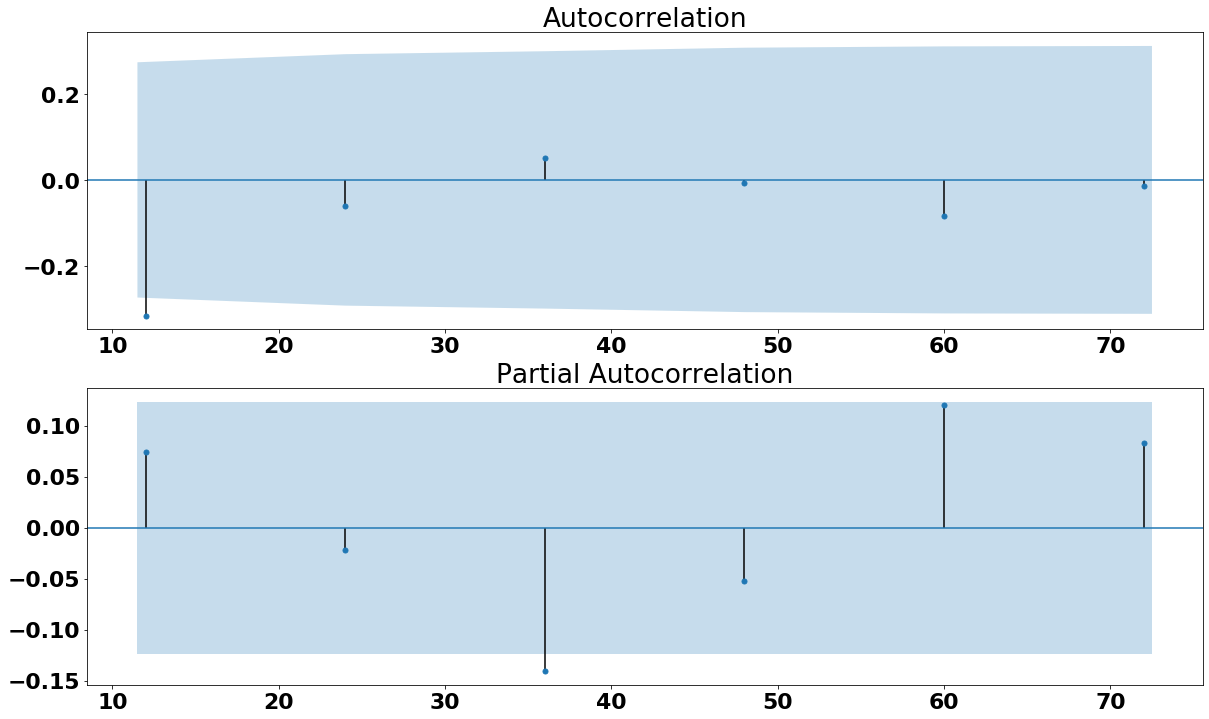

In [73]:
seasonal_plots(ts_30064_diff, N=13)

In [74]:
dftest = pm.auto_arima(ts_30064_diff,information_criterion='aic',m=12,d=1,stepwise=True,trace=True,
                        error_action='ignore',suppress_warnings=True)
dftest

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-2538.505, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-2421.012, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-2430.094, Time=0.27 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-2447.178, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-2423.005, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-2544.491, Time=0.51 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-2531.423, Time=0.22 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-2559.678, Time=0.85 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-2553.047, Time=2.58 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=-2567.069, Time=1.44 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=-2551.738, Time=0.52 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=-2561.283, Time=1.52 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=-2545.790, Time=0.58 sec
 ARIMA(0,1,2)(0,0,2)[12] intercept   : AIC=-2572.329, Time=1.00 sec
 ARIM

ARIMA(order=(0, 1, 3), scoring_args={}, seasonal_order=(0, 0, 2, 12),
      suppress_warnings=True, with_intercept=False)

                                        SARIMAX Results                                        
Dep. Variable:                                      mr   No. Observations:                  228
Model:             SARIMAX(0, 1, 3)x(0, 0, [1, 2], 12)   Log Likelihood                1130.801
Date:                                 Wed, 16 Sep 2020   AIC                          -2249.602
Time:                                         10:01:19   BIC                          -2229.052
Sample:                                     05-01-1996   HQIC                         -2241.310
                                          - 04-01-2015                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5349      0.062      8.671      0.000       0.414       0

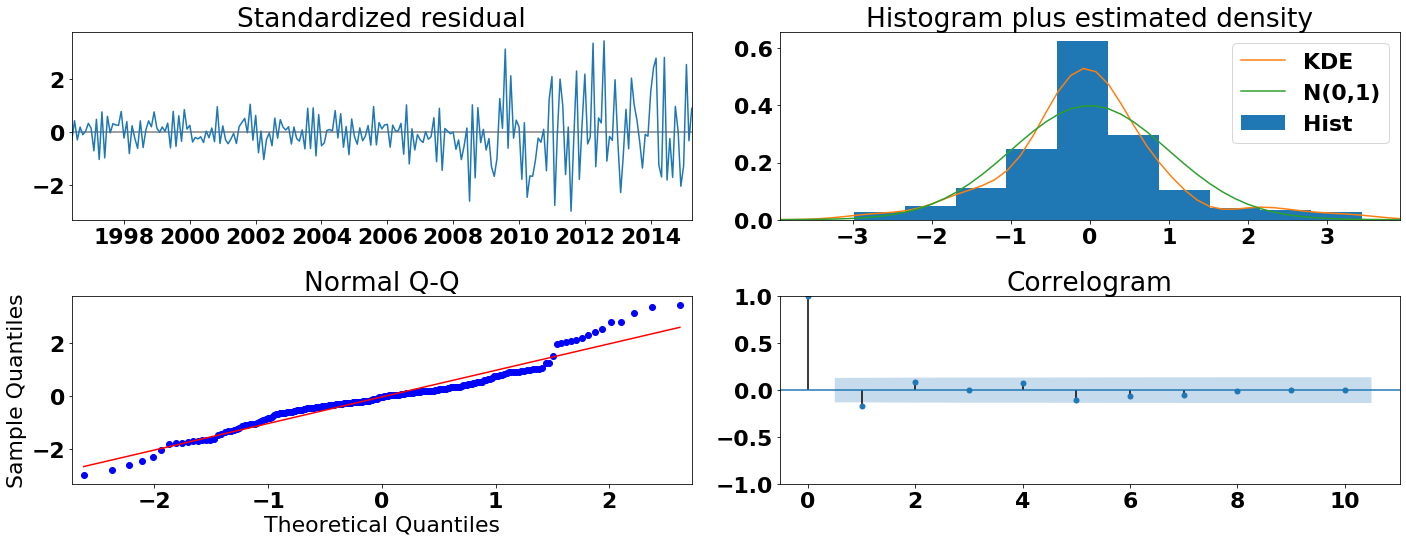

In [75]:
# SARIMA model parameters
# p = 0 d = 1 q = 3
# P = 0 D = 0 Q = 2 S = 12

# Fit SARIMA model
pdq = (0,1,3)
pdqs = (0,0,2,12)
train, test, results = model_fit(ts_30064,pdq=pdq,pdqs=pdqs)

SARIMA model RMSE on train data: 0.00242


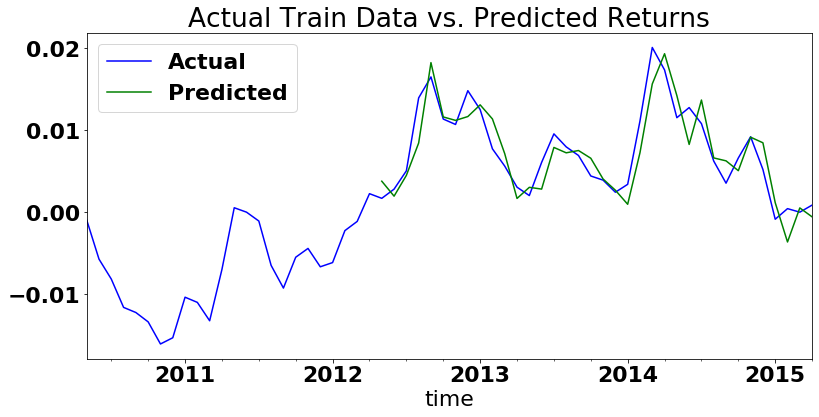

In [76]:
train_RMSE(train, results)

SARIMA model RMSE on test data: 0.00196


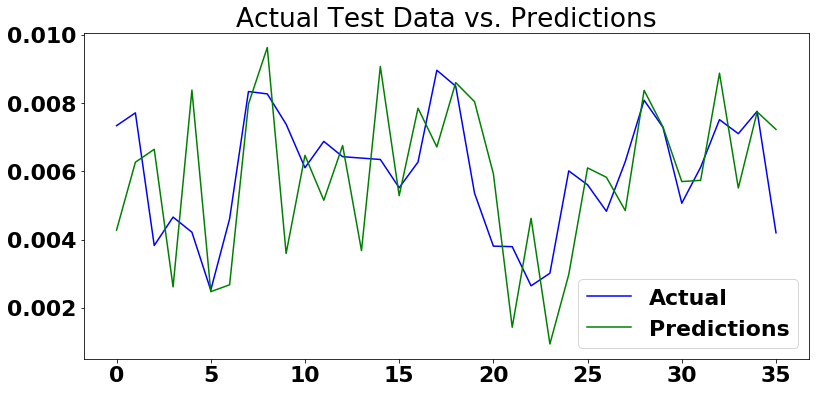

In [77]:
test_RMSE(ts_30064,pdq=pdq,pdqs=pdqs, display=True)

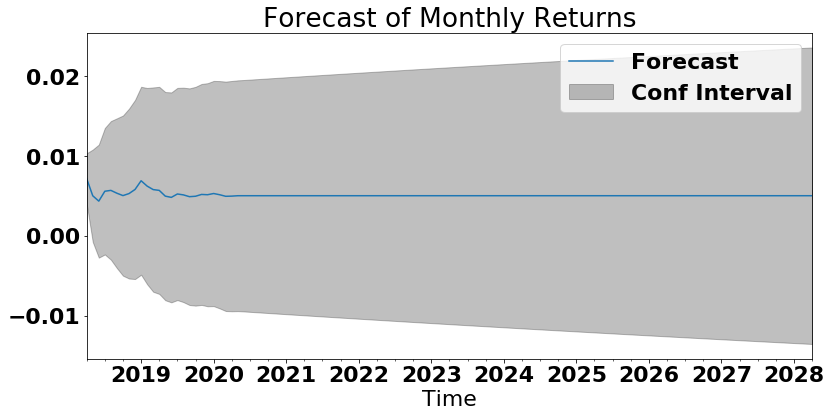

Expected 1yr return: 7.06%
Expected 3yr return: 20.91%
Expected 5yr return: 36.41%
Expected 10yr return: 85.34%


In [78]:
mr_30064=forecast_model(ts_30064,pdq=pdq,pdqs=pdqs, z=30064)

### 5d) Zip code #4 : 30152 (Kennesaw, GA)

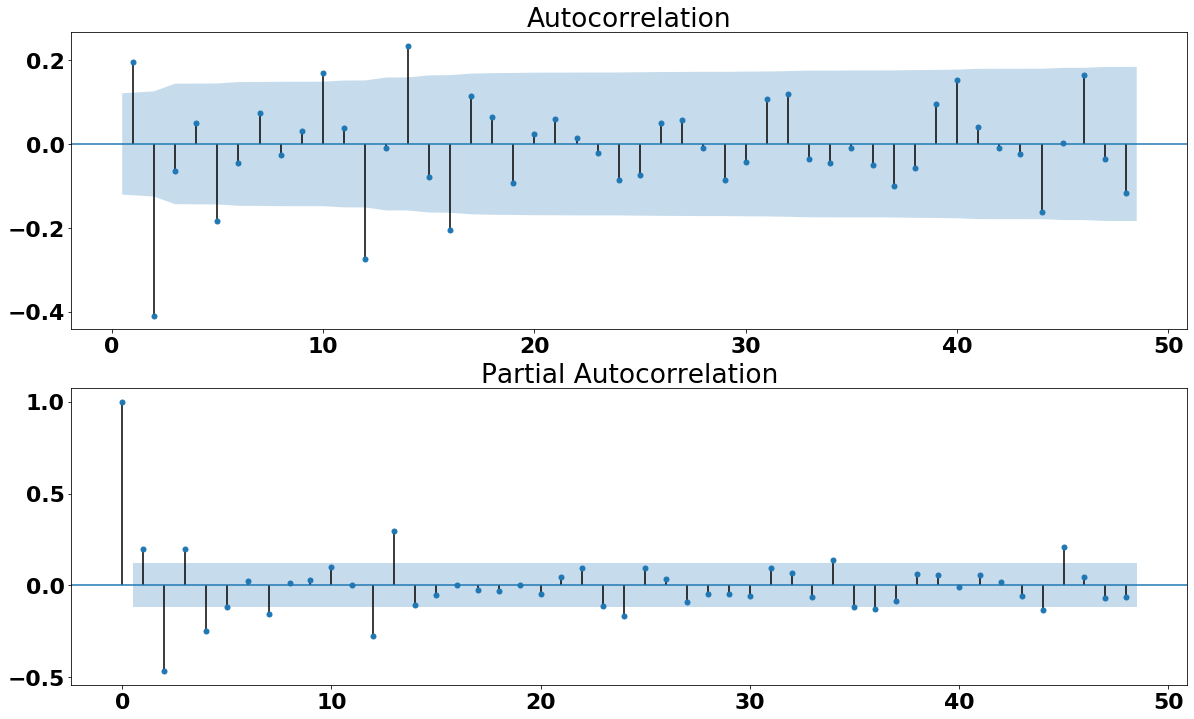

In [79]:
acf_pacf(ts_30152_diff)

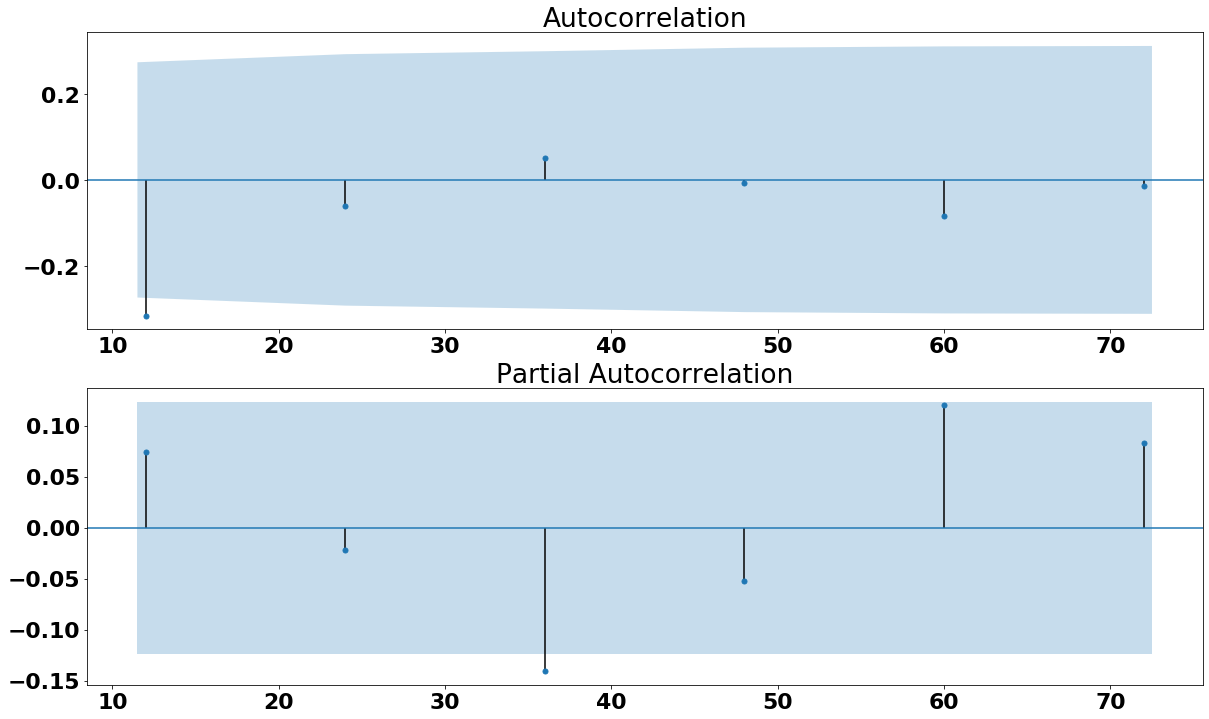

In [80]:
seasonal_plots(ts_30152_diff, N=13)

In [81]:
dftest = pm.auto_arima(ts_30152_diff,information_criterion='aic',m=12,d=1,stepwise=True,trace=True,
                        error_action='ignore',suppress_warnings=True)
dftest

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-2527.236, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-2347.654, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-2383.817, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-2417.882, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-2349.649, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-2543.416, Time=0.54 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-2511.737, Time=0.16 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-2546.698, Time=0.77 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-2542.022, Time=0.82 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=-2408.069, Time=0.63 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=-2505.910, Time=1.76 sec
 ARIMA(3,1,2)(0,0,2)[12] intercept   : AIC=-2400.444, Time=1.39 sec
 ARIMA(2,1,3)(0,0,2)[12] intercept   : AIC=-2582.300, Time=3.53 sec
 ARIMA(2,1,3)(0,0,1)[12] intercept   : AIC=-2572.761, Time=0.68 sec
 ARIM

ARIMA(order=(1, 1, 4), scoring_args={}, seasonal_order=(0, 0, 2, 12),
      suppress_warnings=True, with_intercept=False)

                                        SARIMAX Results                                        
Dep. Variable:                                      mr   No. Observations:                  228
Model:             SARIMAX(1, 1, 4)x(0, 0, [1, 2], 12)   Log Likelihood                1130.907
Date:                                 Wed, 16 Sep 2020   AIC                          -2245.814
Time:                                         10:02:22   BIC                          -2218.414
Sample:                                     05-01-1996   HQIC                         -2234.758
                                          - 04-01-2015                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0279      0.313     -0.089      0.929      -0.641       0

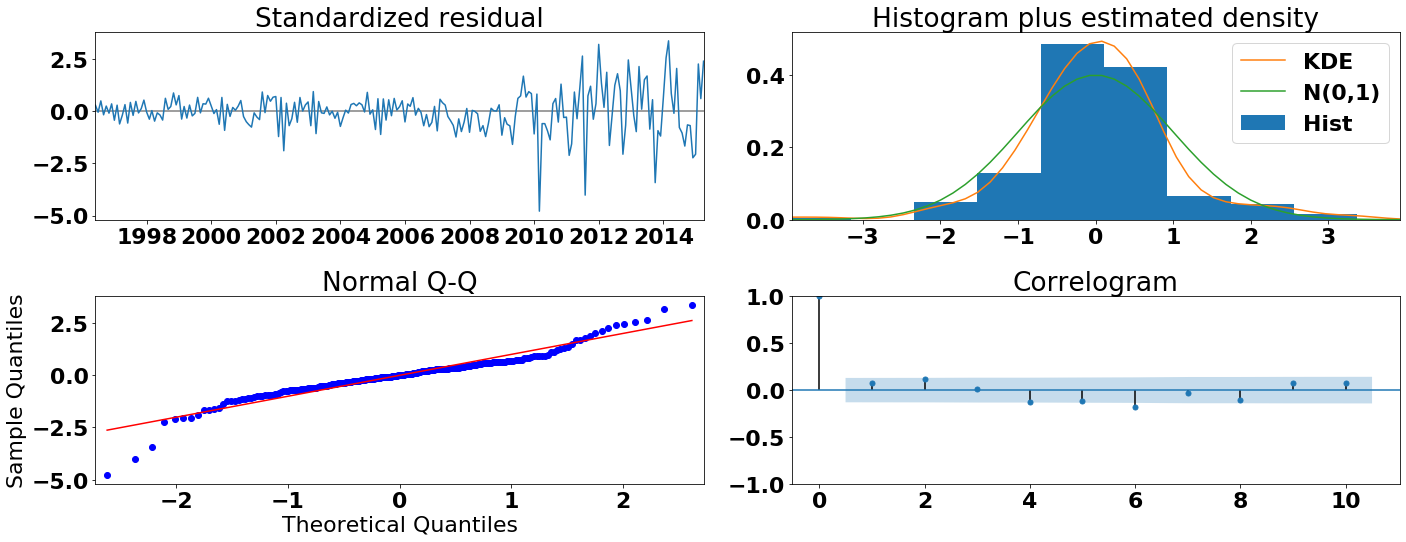

In [82]:
# SARIMA model parameters
# p = 1 d = 1 q = 4
# P = 0 D = 0 Q = 2 S = 12

# Fit SARIMA model
pdq = (1,1,4)
pdqs = (0,0,2,12)
train, test, results = model_fit(ts_30152,pdq=pdq,pdqs=pdqs)

SARIMA model RMSE on train data: 0.00264


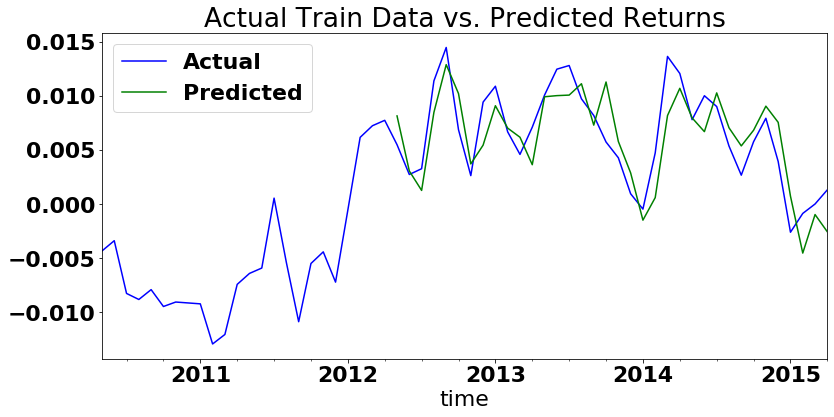

In [83]:
train_RMSE(train, results)

SARIMA model RMSE on test data: 0.00193


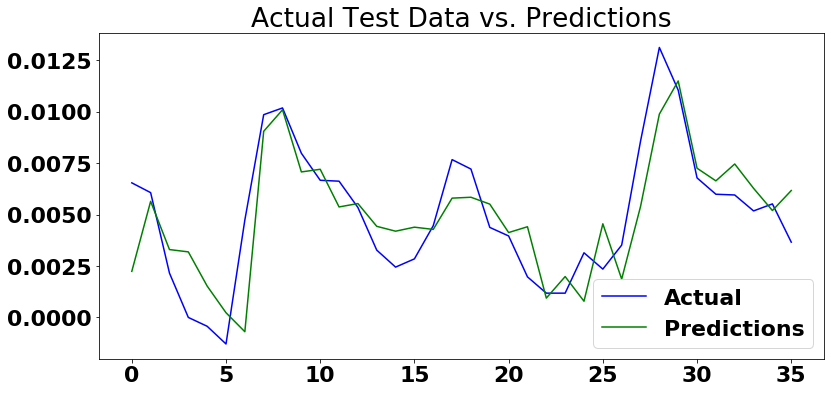

In [84]:
test_RMSE(ts_30152,pdq=pdq,pdqs=pdqs, display=True)

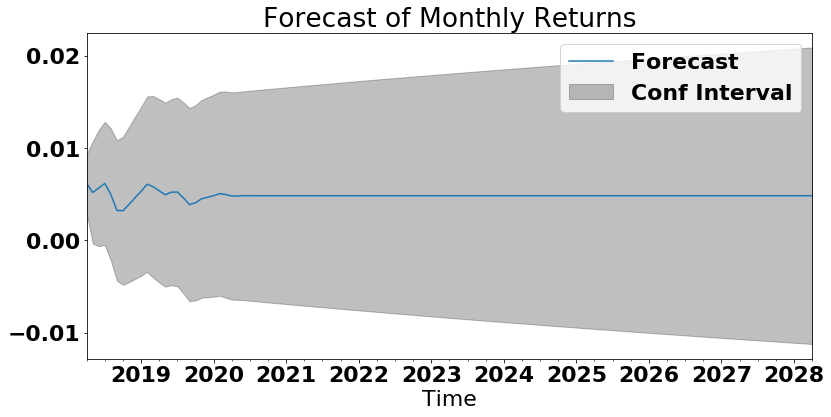

Expected 1yr return: 6.19%
Expected 3yr return: 19.12%
Expected 5yr return: 33.72%
Expected 10yr return: 79.4%


In [85]:
mr_30152=forecast_model(ts_30152,pdq=pdq,pdqs=pdqs, z=30152)

### 5e) Zip code #5 : 30101 (Acworth, GA)

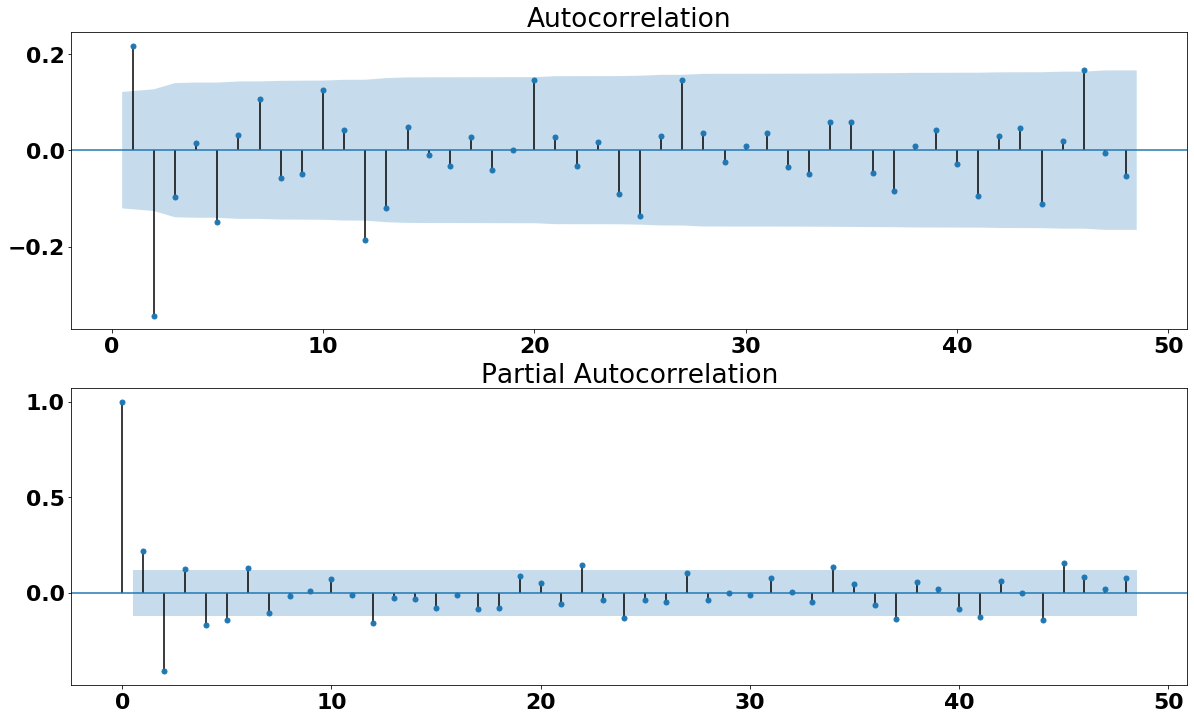

In [86]:
acf_pacf(ts_30101_diff)

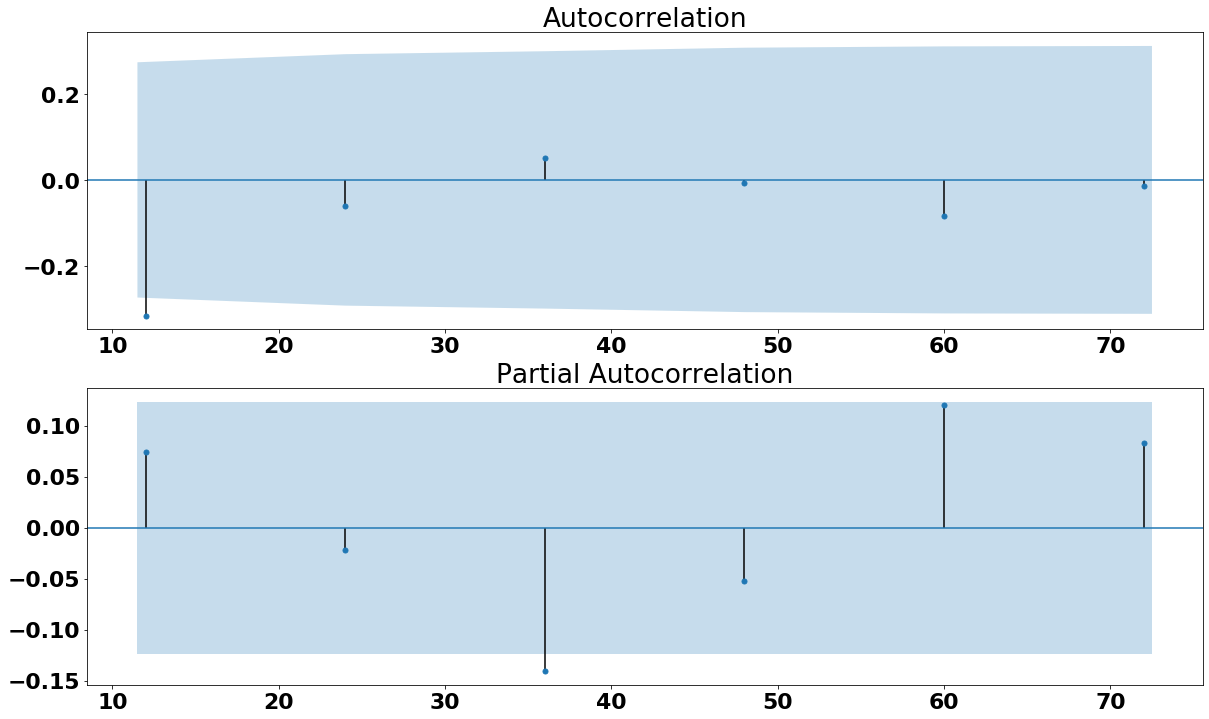

In [87]:
seasonal_plots(ts_30101_diff, N=13)

In [88]:
dftest = pm.auto_arima(ts_30101_diff,information_criterion='aic',m=12,d=1,stepwise=True,trace=True,
                        error_action='ignore',suppress_warnings=True)
dftest

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-2550.504, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-2409.350, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-2420.284, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-2441.357, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-2411.343, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-2555.104, Time=0.51 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-2551.619, Time=0.31 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-2531.861, Time=2.07 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-2554.736, Time=0.55 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-2530.253, Time=2.21 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=-2417.723, Time=0.50 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=-2515.835, Time=0.31 sec
 ARIMA(3,1,2)(0,0,1)[12] intercept   : AIC=-2535.045, Time=0.84 sec
 ARIMA(2,1,3)(0,0,1)[12] intercept   : AIC=-2581.989, Time=1.10 sec
 ARIM

ARIMA(order=(1, 1, 4), scoring_args={}, seasonal_order=(2, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

                                      SARIMAX Results                                      
Dep. Variable:                                  mr   No. Observations:                  228
Model:             SARIMAX(1, 1, 4)x(2, 0, [], 12)   Log Likelihood                1143.769
Date:                             Wed, 16 Sep 2020   AIC                          -2271.538
Time:                                     10:03:32   BIC                          -2244.138
Sample:                                 05-01-1996   HQIC                         -2260.482
                                      - 04-01-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0677      0.420     -0.161      0.872      -0.892       0.756
ma.L1          0.4518      

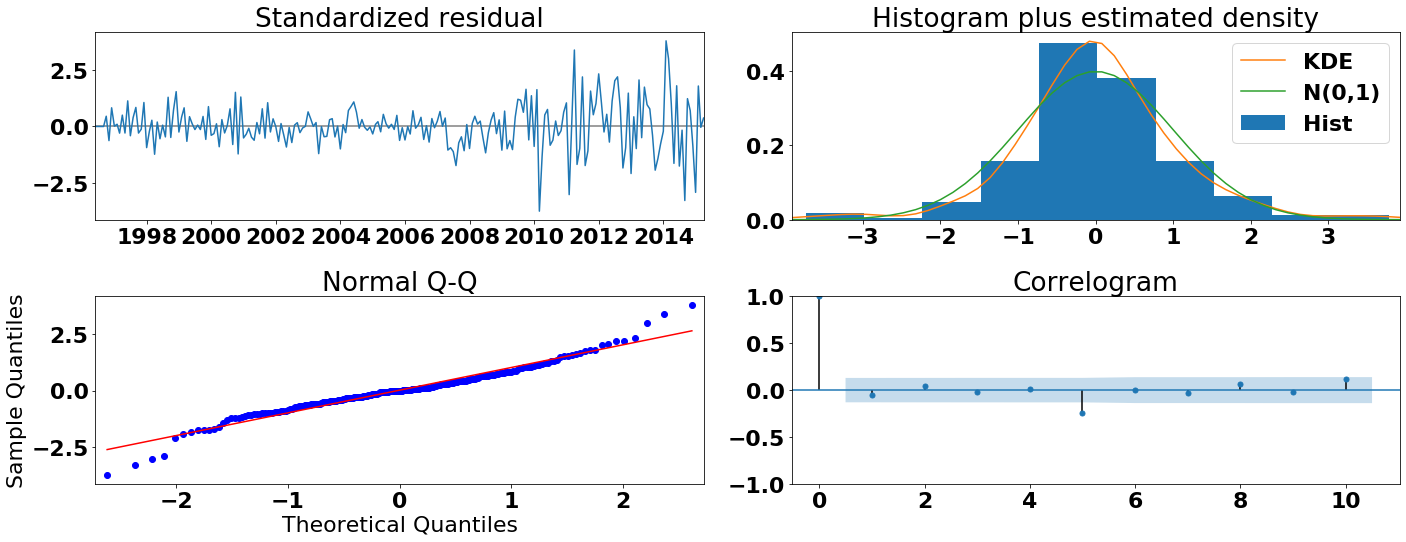

In [89]:
# SARIMA model parameters
# p = 1 d = 1 q = 4
# P = 2 D = 0 Q = 0 S = 12

# Fit SARIMA model
pdq = (1,1,4)
pdqs = (2,0,0,12)
train, test, results = model_fit(ts_30101,pdq=pdq,pdqs=pdqs)

SARIMA model RMSE on train data: 0.00256


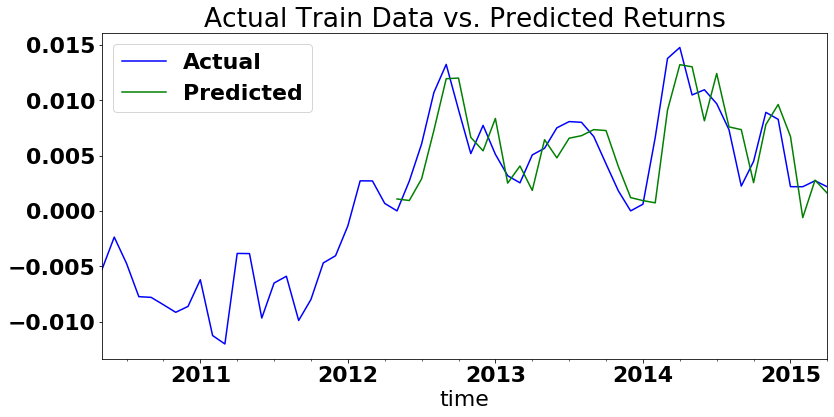

In [90]:
train_RMSE(train, results)

SARIMA model RMSE on test data: 0.00208


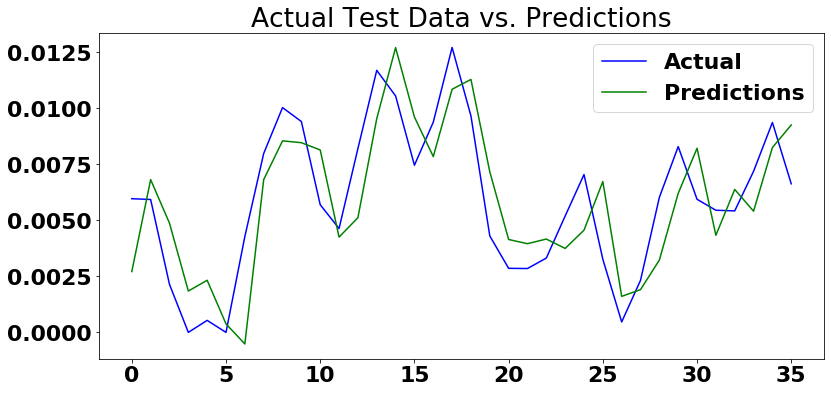

In [91]:
test_RMSE(ts_30101,pdq=pdq,pdqs=pdqs, display=True)

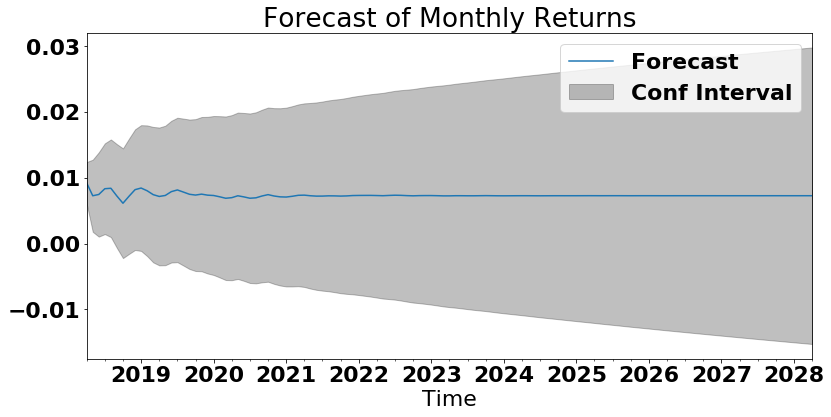

Expected 1yr return: 9.74%
Expected 3yr return: 30.65%
Expected 5yr return: 55.5%
Expected 10yr return: 141.87%


In [92]:
mr_30101=forecast_model(ts_30101,pdq=pdq,pdqs=pdqs, z=30101)

# Step 6: Interpreting Results

In [93]:
# Forecasting return on investment

investment_returns = [mr_30080,mr_30066,mr_30064,mr_30152,mr_30101]
investment_returns = pd.DataFrame(investment_returns,columns=['Zip_code','1-year','3-year','5-year','10-year'])
investment_returns.sort_values('10-year',ascending=False)

,Zip_code,1-year,3-year,5-year,10-year
0,30080,0.197078,0.660650,1.305305,4.306268
4,30101,0.097371,0.306521,0.554979,1.418744
1,30066,0.087136,0.275718,0.496382,1.244653
2,30064,0.070551,0.209100,0.364081,0.853392
3,30152,0.061901,0.191199,0.337209,0.794028


## Business Reccomendations

#### After performing time series analysis on the top 5 zipcodes in the greater atlanta area, I recommend investing in 3:

#### 1) 30080 (Smyrna, GA) -> 10-yr return = 430.62%
#### 2) 30101 (Acworth, GA) -> 10-yr return = 141.87%
#### 3) 30066 (Marietta, GA) -> 10-yr return = 124.46%

#### The predicted return on investment for zip code 30080 is much higher than the other, look in Smyrna, GA first.

## Resources

In [94]:
# https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
# https://www.kaggle.com/sumi25/understand-arima-and-tune-p-d-q
# https://medium.com/@feraguilari/time-series-analysis-modfinalproyect-b9fb23c28309
# https://ilonabrodovska.wordpress.com/2017/06/05/creating-a-time-series-forecast-python-3-step-by-step-guide/
# https://github.com/DTrimarchi10/Mod4Project/blob/master/Mod_4_project.ipynb
# https://github.com/lraichik/Predicting-average-real-estate-prices-by-zipcode/blob/master/Brooklyn.ipynb